In [3]:
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pickle
import glob
import cv2
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as trainTestSplit

from skimage.feature import hog
from skimage import color, exposure


Using TensorFlow backend.


In [ ]:
def timeStamp():
    now = datetime.datetime.now()
    y = now.year
    d = now.day
    mo = now.month
    h = now.hour
    m = now.minute
    s = now.second

    return '{}_{}_{}_{}_{}_{}'.format(y, mo, d, h, m, s)


### Load The Data

In [5]:
dataFile = 'sample_data_file_names.p'

if not os.path.isfile(dataFile):
    cars_samples = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
    not_cars_samples = glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')

    image_samples = cars_samples + not_cars_samples
    y = np.concatenate((np.ones(len(cars_samples)), np.zeros(len(not_cars_samples))))

    imageSamplesFiles, y = shuffle(image_samples, y)
    X_train, X_test, y_train, y_test = trainTestSplit(imageSamplesFiles, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = trainTestSplit(X_train, y_train, test_size=0.2, random_state=42)

    data = {'X_train': X_train, 'X_test': X_test, 'X_valid': X_valid, 'y_train': y_train, 'y_test': y_test, 'y_valid': y_valid}
    pickle.dump(data, open(dataFile, 'wb'))

with open(dataFile, mode='rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    X_test = data['X_test']
    X_valid = data['X_valid']
    y_train = data['y_train']
    y_test = data['y_test']
    y_valid = data['y_valid']

train_samples = [(X_train[i], y_train[i]) for i in range(len(X_train))] 
test_samples = [(X_test[i], y_test[i]) for i in range(len(X_test))] 
validation_samples = [(X_valid[i], y_valid[i]) for i in range(len(X_valid))] 


### Dataset Summary & Exploration

In [8]:
# Number of training examples
n_train = format(len(X_train))

# Number of validation examples
n_validation = format(len(X_valid))

# Number of testing examples
n_test = format(len(X_test))

# Shape of an traffic sign image
#image_shape = format(X_train[0].shape)


print()
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print()
#print("Image data shape =", image_shape)



Number of training examples = 1484
Number of validation examples = 372
Number of testing examples = 465



In [12]:
img_input_shape=(720, 1280, 3)
height_of_interest = (400, 700)
model_input_shape = (height_of_interest[1] - height_of_interest[0], img_input_shape[1], img_input_shape[2])
print(model_input_shape)

(300, 1280, 3)


### Model Architecture

In [40]:
from keras.layers import Conv2D, Flatten, Lambda, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential

def generate_model(input_shape=(64, 64, 3)):
    dropout = 0.5
    model = Sequential()
    #normalization and mean zero - centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x / 255., input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=1, kernel_size=(8, 8), activation="sigmoid"))
    return model

In [57]:
import cv2
import numpy as np
import random
from sklearn.utils import shuffle

def generator(samples, batch_size=32, is_training=False):
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images, classification = [], []
            X_train, y_train = [], []
            
            for batch_sample in batch_samples:
                fileName = batch_sample[0]
                image = cv2.imread(fileName)
                
                # Adding the original images, flipping them and append to the dataset
                images.append(image)
                classification.append(batch_sample[1])
                
                if (is_training):
                    images.append(cv2.flip(image, 1))
                    classification.append(batch_sample[1])
                 
            X_train = np.array(images)
            y_train = np.expand_dims(classification, axis=1)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
batch_size = 32
train_generator = generator(train_samples, batch_size, is_training=True)
validation_generator = generator(validation_samples, batch_size)
test_generator = generator(test_samples, batch_size)

In [51]:
from time import time
start_time = time()

epochs=2
batch_size = 32

model = generate_model()
model = Model(inputs=model.input, outputs=Flatten()(model.output))
print(model.summary())
        
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_object = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)*2/batch_size, 
                validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size,
                epochs=epochs, callbacks=[checkpoint])

total_time = time() - start_time
minutes, seconds = divmod(total_time, 60)
print ("Total time for training: ", minutes, "min, {:.0f}".format(seconds),  "s ")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_17_input (InputLayer) (None, 64, 64, 3)         0         
_________________________________________________________________
lambda_17 (Lambda)           (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
dropout_49 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
dropout_50 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 64, 64, 64)        18496     
__________

In [55]:
accuracy = model.evaluate_generator(generator=test_generator, steps=len(test_samples)/ batch_size)

print('Test accuracy: ', accuracy)

Test accuracy:  [0.044455069231410183, 0.95913978494623653]


In [68]:
detectionPointSize = 64
confidenceThrd = .5 #.7

cnnModel = generate_model(input_shape=(300, 1280, 3))
#cnnModel.load_weights('weights-improvement-2017_9_26_9_38_45.h5')
cnnModel.load_weights('ppico.h5')

veHiDepth = 3
vehicleBoxesHistory = []
groupThrd = 4
groupDiff = .1

# Custom kernel to consolidate diagonally-touching areas
diagKernel = [[1, 1, 1],[1, 1, 1],[1, 1, 1]]


[[785, 400, 954, 499], [1088, 400, 1279, 545], [785, 400, 954, 499], [1088, 400, 1279, 545]]
()


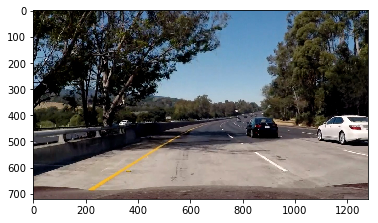

In [73]:
%matplotlib inline

def vehicleScan(img):

    # Cropping to the region of interest
    roi = img[crop[0]:crop[1], :]

    roiW, roiH = roi.shape[1], roi.shape[0]

    # Going 4-D
    roi = np.expand_dims(roi, axis=0)

    # Single-Feature top convolutional layer, which represents a
    # miniaturized (25x153) version of the ROI with the vehicle's probability at each point
    detectionMap = cnnModel.predict(roi)
    #print(detectionMap)

    predictionMapH, predictionMapW = detectionMap.shape[1], detectionMap.shape[2]

    ratioH, ratioW = roiH / predictionMapH, roiW / predictionMapW

    # Prediction output is 4-D tensor: (1, H, W, 1) in this particular case,
    # thus converting to 2-D, effectively represents it as a single-channel image
    detectionMap = detectionMap.reshape(detectionMap.shape[1], detectionMap.shape[2])

    # Thresholding by the confidence. The predictions are actually VERY polarized,
    # sticking to mostly Zero for non-vehicle points and mostly Ones for vehicles.
    # That said, midpoint of 0.5 for confidence threshold seems to be a reliable choice.
    detectionMap = detectionMap > confidenceThrd

    labels = label(detectionMap, structure=diagKernel)

    hotPoints = []

    # Considering obtained labels as vehicles.
    for vehicleID in range(labels[1]):
        #print(vehicleID)
        nz = (labels[0] == vehicleID + 1).nonzero()
        nzY = np.array(nz[0])
        nzX = np.array(nz[1])

        # +/-'s are manually derived adjustments for more appropriate boxes visualization
        xMin = np.min(nzX) - 32
        xMax = np.max(nzX) + 32

        yMin = np.min(nzY)
        yMax = np.max(nzY) + 64

        # This used to keep generated bounding boxes within a range of the label (a.k.a. vehicle) boundaries
        spanX = xMax - xMin
        spanY = yMax - yMin

        for x, y in zip(nzX, nzY):

            # Adjustment offsets for a box starting point.
            # Ranges from 0 for the left(upper)-most to detectionPointSize for right(bottom)-most
            offsetX = (x - xMin) / spanX * detectionPointSize
            offsetY = (y - yMin) / spanY * detectionPointSize

            # Getting boundaries in ROI coordinates scale (multiplying by ratioW, ratioH)
            topLeftX = int(round(x * ratioW - offsetX, 0))
            topLeftY = int(round(y * ratioH - offsetY, 0))
            bottomLeftX = topLeftX + detectionPointSize
            bottomLeftY = topLeftY + detectionPointSize

            topLeft = (topLeftX, crop[0] + topLeftY)
            bottomRight = (bottomLeftX, crop[0] + bottomLeftY)

            hotPoints.append((topLeft, bottomRight))

    return hotPoints
    
def addHeat(mask, bBoxes):
    """
    Creates the actual heat map. Overlaps build-up the 'heat'
    :param mask: the image where the 'heat' being projected
    :param bBoxes: bounding boxes formatted as list of tuples of tuples: [((x, y), (x, y)),...]
    :return: 1-channel Heat map image
    """
    for box in bBoxes:
        # box as ((x, y), (x, y))
        topY = box[0][1]
        bottomY = box[1][1]
        leftX = box[0][0]
        rightX = box[1][0]

        mask[topY:bottomY, leftX:rightX] += 1

        mask = np.clip(mask, 0, 255)

    return mask
    
def getHotRegions(img):
    """
    Getting hot regions as a labeled features within a current frame + heat map for visualization
    :param src: current frame (3-channel RGB image)
    :return: hot regions as a labeled features, heat map
    """
    hotPoints = vehicleScan(img)
    #print(hotPoints)
    sampleMask = np.zeros_like(img[:, :, 0]).astype(np.float)
    heatMap = addHeat(mask=sampleMask, bBoxes=hotPoints)
    #plt.imshow(heatMap)
    # Filtering outliers
    #heatMap[heatMap <= 3] = 0
    currentFrameBoxes = label(heatMap, structure=diagKernel)
    #print(currentFrameBoxes)
    return currentFrameBoxes, heatMap
    
def updateHistory(currentLabels):
    """
    Converting hot regions to bounding boxes and saving them to boxes history list
    :param currentLabels: current frame hot regions as labeled features
    :return: void
    """
    for i in range(currentLabels[1]):
        nz = (currentLabels[0] == i + 1).nonzero()
        nzY = np.array(nz[0])
        nzX = np.array(nz[1])

        tlX = np.min(nzX)
        tlY = np.min(nzY)
        brX = np.max(nzX)
        brY = np.max(nzY)

        global vehicleBoxesHistory
        vehicleBoxesHistory.append([tlX, tlY, brX, brY])

        # Keeping last elements in history. Number defined by self.VeHiDepth
        vehicleBoxesHistory = vehicleBoxesHistory[-45:]

def colorHeatMap(heatMapMono, cmap=cv2.COLORMAP_HOT):
    """
    Makes an RGB version of the 1-channel heatMap
    :param heatMapMono: 
    :param cmap: The color map of choice
    :return: RGB heatMap
    """
    heatMapInt = cv2.equalizeHist(heatMapMono.astype(np.uint8))
    heatColor = cv2.applyColorMap(heatMapInt, cmap)
    heatColor = cv2.cvtColor(heatColor, code=cv2.COLOR_BGR2RGB)

    return heatColor

def relevantBoxes(img):
    """
    Extracts vehicles bounding boxes
    :param src: currentFrame
    :return: boxes, color heat map (for visualization)
    """
    currentLabels, heatMapGray = getHotRegions(img)

    heatColor = colorHeatMap(heatMapMono=heatMapGray, cmap=cv2.COLORMAP_JET)
    #plt.imshow(heatColor)
    updateHistory(currentLabels=currentLabels)

    global vehicleBoxesHistory
    print(vehicleBoxesHistory)
    boxes, _ = cv2.groupRectangles(rectList=np.array(vehicleBoxesHistory).tolist(), groupThreshold=10, eps=.1)
    print(boxes)
    return boxes, heatColor

def drawBoxes(img, bBoxes, color=(0, 255, 0), thickness=4):
    """
    Universal bounding box painter, regardless of bBoxes format 
    :param img: image of interest
    :param bBoxes: list of bounding boxes.
    :param color: 
    :param thickness: 
    :return: 
    """
    for bBox in bBoxes:

        bBox = np.array(bBox)
        bBox = bBox.reshape(bBox.size)

        cv2.rectangle(img=img, pt1=(bBox[0], bBox[1]), pt2=(bBox[2], bBox[3]), color=color, thickness=thickness)

def detect_vehicles(img):
    vBoxes, heatMap = relevantBoxes(img)
    drawBoxes(img, vBoxes)
    return img

#for i in range(10):
img = mpimg.imread('C:\\data\\detection\\templates\\test5.jpg')
output = detect_vehicles(img)
plt.imshow(output)

[[785, 400, 954, 499], [1088, 400, 1279, 545]]
[[ 785  400  954  499]
 [1088  400 1279  545]]


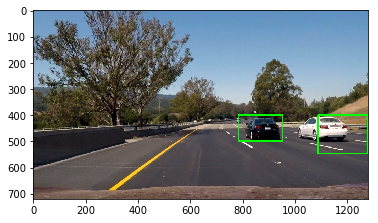

In [72]:
%matplotlib inline
test = [[785, 400, 954, 499], [1088, 400, 1279, 545]]
boxes, _ = cv2.groupRectangles(rectList=np.array(test).tolist(), groupThreshold=0, eps=0)
img = mpimg.imread('C:\\data\\detection\\templates\\test6.jpg')
drawBoxes(img, boxes)
print(test)
print(boxes)
plt.imshow(img)

[[785, 400, 954, 520], [1031, 400, 1269, 520], [785, 400, 954, 501], [1088, 400, 1279, 549], [785, 400, 954, 501], [1088, 400, 1279, 549]]


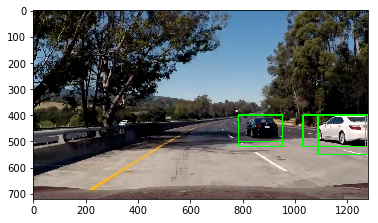

In [130]:
def detect_vehicles(img):
    vBoxes, heatMap = relevantBoxes(img)
    drawBoxes(img, vBoxes)
    return img

img = mpimg.imread('C:\\data\\detection\\templates\\test5.jpg')
output = detect_vehicles(img)
plt.imshow(output)

In [194]:
# Test the pipeline for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = ('C:\\data\\detection\\project_video_output.mp4')
clip1 = VideoFileClip("C:\\data\\detection\\project_video.mp4")
white_clip = clip1.fl_image(detect_vehicles)#.subclip(6,10)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

  0%|          | 0/1261 [00:00<?, ?it/s]

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

  0%|          | 1/1261 [00:01<26:12,  1.25s/it]

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

  0%|          | 2/1261 [00:02<23:19,  1.11s/it]

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

  0%|          | 3/1261 [00:02<21:27,  1.02s/it]

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

  0%|          | 4/1261 [00:03<20:24,  1.03it/s]

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

  0%|          | 5/1261 [00:04<19:30,  1.07it/s]

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

  0%|          | 6/1261 [00:05<19:35,  1.07it/s]

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

  1%|          | 7/1261 [00:06<19:14,  1.09it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539]

  1%|          | 8/1261 [00:07<19:31,  1.07it/s]

[[1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539]

  1%|          | 9/1261 [00:08<19:23,  1.08it/s]

[[1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539]

  1%|          | 10/1261 [00:09<18:51,  1.11it/s]

[[1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539]

  1%|          | 11/1261 [00:10<19:07,  1.09it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  1%|          | 12/1261 [00:10<18:56,  1.10it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  1%|          | 13/1261 [00:11<18:21,  1.13it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  1%|          | 14/1261 [00:12<17:43,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  1%|          | 15/1261 [00:13<17:17,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  1%|▏         | 16/1261 [00:14<17:54,  1.16it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  1%|▏         | 17/1261 [00:15<17:45,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  1%|▏         | 18/1261 [00:15<17:11,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  2%|▏         | 19/1261 [00:16<17:00,  1.22it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  2%|▏         | 20/1261 [00:17<16:52,  1.23it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  2%|▏         | 21/1261 [00:18<16:33,  1.25it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  2%|▏         | 22/1261 [00:19<16:21,  1.26it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  2%|▏         | 23/1261 [00:19<16:16,  1.27it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  2%|▏         | 24/1261 [00:20<16:21,  1.26it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  2%|▏         | 25/1261 [00:21<16:51,  1.22it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], 

  2%|▏         | 26/1261 [00:22<17:00,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  2%|▏         | 27/1261 [00:23<17:01,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  2%|▏         | 28/1261 [00:24<17:25,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  2%|▏         | 29/1261 [00:24<17:21,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  2%|▏         | 30/1261 [00:25<17:22,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  2%|▏         | 31/1261 [00:26<17:13,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 32/1261 [00:27<16:43,  1.22it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 33/1261 [00:28<16:21,  1.25it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 34/1261 [00:28<16:09,  1.27it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 35/1261 [00:29<15:55,  1.28it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 36/1261 [00:30<15:48,  1.29it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 37/1261 [00:31<15:42,  1.30it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 38/1261 [00:31<15:37,  1.30it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 39/1261 [00:32<15:36,  1.31it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 40/1261 [00:33<15:37,  1.30it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 41/1261 [00:34<15:37,  1.30it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 42/1261 [00:35<15:56,  1.28it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 43/1261 [00:35<16:25,  1.24it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  3%|▎         | 44/1261 [00:36<16:30,  1.23it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▎         | 45/1261 [00:37<16:55,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▎         | 46/1261 [00:38<17:00,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▎         | 47/1261 [00:39<17:06,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 48/1261 [00:40<17:15,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 49/1261 [00:41<17:23,  1.16it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 50/1261 [00:41<17:03,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 51/1261 [00:42<16:54,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 52/1261 [00:43<16:54,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 53/1261 [00:44<16:53,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 54/1261 [00:45<16:45,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 55/1261 [00:46<16:38,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  4%|▍         | 56/1261 [00:46<16:48,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▍         | 57/1261 [00:47<16:27,  1.22it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▍         | 58/1261 [00:48<16:10,  1.24it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▍         | 59/1261 [00:49<16:04,  1.25it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▍         | 60/1261 [00:50<16:01,  1.25it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▍         | 61/1261 [00:50<16:01,  1.25it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▍         | 62/1261 [00:51<15:54,  1.26it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▍         | 63/1261 [00:52<15:46,  1.27it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▌         | 64/1261 [00:53<16:04,  1.24it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▌         | 65/1261 [00:54<16:09,  1.23it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▌         | 66/1261 [00:54<16:12,  1.23it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▌         | 67/1261 [00:55<16:21,  1.22it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▌         | 68/1261 [00:56<16:23,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  5%|▌         | 69/1261 [00:57<16:18,  1.22it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 70/1261 [00:58<16:26,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 71/1261 [00:58<16:17,  1.22it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 72/1261 [00:59<16:24,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 73/1261 [01:00<16:21,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 74/1261 [01:01<16:20,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 75/1261 [01:02<16:25,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 76/1261 [01:03<16:41,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 77/1261 [01:04<19:32,  1.01it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▌         | 78/1261 [01:05<18:28,  1.07it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▋         | 79/1261 [01:06<17:39,  1.12it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▋         | 80/1261 [01:07<17:23,  1.13it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  6%|▋         | 81/1261 [01:07<16:48,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 82/1261 [01:08<16:34,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 83/1261 [01:09<16:24,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 84/1261 [01:10<16:24,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 85/1261 [01:11<16:20,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 86/1261 [01:11<16:13,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 87/1261 [01:12<16:03,  1.22it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 88/1261 [01:13<16:45,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 89/1261 [01:14<16:35,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 90/1261 [01:15<16:37,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 91/1261 [01:16<16:40,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 92/1261 [01:17<17:08,  1.14it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 93/1261 [01:18<17:10,  1.13it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  7%|▋         | 94/1261 [01:18<16:38,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 95/1261 [01:19<16:34,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 96/1261 [01:20<16:14,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 97/1261 [01:21<16:15,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 98/1261 [01:22<16:15,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 99/1261 [01:22<16:02,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 100/1261 [01:23<15:46,  1.23it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 101/1261 [01:24<15:35,  1.24it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 102/1261 [01:25<15:56,  1.21it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 103/1261 [01:26<16:06,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 104/1261 [01:27<16:04,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 105/1261 [01:27<16:13,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 106/1261 [01:28<16:09,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  8%|▊         | 107/1261 [01:29<16:26,  1.17it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▊         | 108/1261 [01:30<16:39,  1.15it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▊         | 109/1261 [01:31<16:18,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▊         | 110/1261 [01:32<16:12,  1.18it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▉         | 111/1261 [01:33<16:05,  1.19it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▉         | 112/1261 [01:33<15:54,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▉         | 113/1261 [01:34<15:56,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▉         | 114/1261 [01:35<15:59,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▉         | 115/1261 [01:36<15:54,  1.20it/s]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [6

  9%|▉         | 116/1261 [01:37<15:47,  1.21it/s]

[[1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 5

  9%|▉         | 117/1261 [01:38<15:50,  1.20it/s]

[[1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 5

  9%|▉         | 118/1261 [01:38<15:32,  1.23it/s]

[[1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 

  9%|▉         | 119/1261 [01:39<15:42,  1.21it/s]

[[1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 12

 10%|▉         | 120/1261 [01:40<15:42,  1.21it/s]

[[1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279

 10%|▉         | 121/1261 [01:41<15:54,  1.19it/s]

[[1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 

 10%|▉         | 122/1261 [01:42<16:14,  1.17it/s]

[[135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 56

 10%|▉         | 123/1261 [01:43<16:39,  1.14it/s]

[[111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 55

 10%|▉         | 124/1261 [01:44<16:59,  1.12it/s]

[[1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 56

 10%|▉         | 125/1261 [01:45<17:18,  1.09it/s]

[[1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 5

 10%|▉         | 126/1261 [01:46<17:56,  1.05it/s]

[[1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560

 10%|█         | 127/1261 [01:47<18:11,  1.04it/s]

[[1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560],

 10%|█         | 128/1261 [01:48<18:19,  1.03it/s]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [

 10%|█         | 129/1261 [01:49<18:32,  1.02it/s]

[[1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [11

 10%|█         | 130/1261 [01:50<18:29,  1.02it/s]

[[1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 

 10%|█         | 131/1261 [01:51<18:57,  1.01s/it]

[[1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400

 10%|█         | 132/1261 [01:52<19:55,  1.06s/it]

[[1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 1

 11%|█         | 133/1261 [01:53<19:54,  1.06s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169,

 11%|█         | 134/1261 [01:54<20:13,  1.08s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 47

 11%|█         | 135/1261 [01:55<20:20,  1.08s/it]

[[1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], 

 11%|█         | 136/1261 [01:56<20:23,  1.09s/it]

[[1039, 400, 1279, 539], [194, 494, 281, 557], [161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192

 11%|█         | 137/1261 [01:57<20:43,  1.11s/it]

[[161, 504, 257, 576], [62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 4

 11%|█         | 138/1261 [01:59<21:06,  1.13s/it]

[[62, 535, 155, 608], [2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184,

 11%|█         | 139/1261 [02:00<21:15,  1.14s/it]

[[2, 556, 80, 628], [420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [11

 11%|█         | 140/1261 [02:01<21:07,  1.13s/it]

[[420, 629, 483, 692], [1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549]

 11%|█         | 141/1261 [02:02<20:52,  1.12s/it]

[[1232, 483, 1279, 556], [253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 54

 11%|█▏        | 142/1261 [02:03<20:40,  1.11s/it]

[[253, 400, 323, 463], [1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 54

 11%|█▏        | 143/1261 [02:04<20:33,  1.10s/it]

[[1223, 483, 1279, 556], [219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 

 11%|█▏        | 144/1261 [02:05<20:07,  1.08s/it]

[[219, 400, 322, 463], [1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 

 11%|█▏        | 145/1261 [02:06<20:01,  1.08s/it]

[[1240, 462, 1279, 554], [211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279

 12%|█▏        | 146/1261 [02:07<19:53,  1.07s/it]

[[211, 400, 314, 463], [1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279

 12%|█▏        | 147/1261 [02:08<19:44,  1.06s/it]

[[1240, 452, 1279, 553], [202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 12

 12%|█▏        | 148/1261 [02:09<19:28,  1.05s/it]

[[202, 400, 306, 463], [1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 12

 12%|█▏        | 149/1261 [02:10<19:11,  1.04s/it]

[[1216, 431, 1279, 561], [194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 

 12%|█▏        | 150/1261 [02:11<19:28,  1.05s/it]

[[194, 400, 298, 463], [1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 

 12%|█▏        | 151/1261 [02:12<19:45,  1.07s/it]

[[1232, 431, 1279, 551], [186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410

 12%|█▏        | 152/1261 [02:14<19:54,  1.08s/it]

[[186, 400, 289, 463], [1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410

 12%|█▏        | 153/1261 [02:15<20:25,  1.11s/it]

[[1232, 431, 1279, 561], [180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 4

 12%|█▏        | 154/1261 [02:16<20:21,  1.10s/it]

[[180, 400, 288, 463], [1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 4

 12%|█▏        | 155/1261 [02:17<20:25,  1.11s/it]

[[1232, 431, 1279, 551], [164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136,

 12%|█▏        | 156/1261 [02:18<20:53,  1.13s/it]

[[164, 400, 279, 463], [1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136,

 12%|█▏        | 157/1261 [02:19<21:12,  1.15s/it]

[[1224, 421, 1279, 560], [155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [113

 13%|█▎        | 158/1261 [02:20<20:51,  1.13s/it]

[[155, 400, 270, 463], [1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [113

 13%|█▎        | 159/1261 [02:22<20:32,  1.12s/it]

[[1224, 421, 1279, 560], [138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1

 13%|█▎        | 160/1261 [02:23<20:43,  1.13s/it]

[[138, 400, 254, 463], [1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1

 13%|█▎        | 161/1261 [02:24<20:49,  1.14s/it]

[[1216, 421, 1279, 550], [122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], 

 13%|█▎        | 162/1261 [02:25<20:55,  1.14s/it]

[[122, 400, 245, 472], [1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], 

 13%|█▎        | 163/1261 [02:26<21:00,  1.15s/it]

[[1192, 421, 1279, 560], [113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549]

 13%|█▎        | 164/1261 [02:27<21:01,  1.15s/it]

[[113, 400, 229, 472], [1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549]

 13%|█▎        | 165/1261 [02:28<21:05,  1.15s/it]

[[1208, 410, 1279, 559], [97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 55

 13%|█▎        | 166/1261 [02:30<21:44,  1.19s/it]

[[97, 400, 212, 472], [1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 54

 13%|█▎        | 167/1261 [02:31<22:23,  1.23s/it]

[[1200, 410, 1279, 559], [80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279,

 13%|█▎        | 168/1261 [02:32<22:44,  1.25s/it]

[[80, 400, 203, 472], [1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279,

 13%|█▎        | 169/1261 [02:34<22:41,  1.25s/it]

[[1200, 410, 1279, 559], [56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 12

 13%|█▎        | 170/1261 [02:35<22:26,  1.23s/it]

[[56, 400, 186, 472], [1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 12

 14%|█▎        | 171/1261 [02:36<22:07,  1.22s/it]

[[1200, 410, 1279, 559], [39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400,

 14%|█▎        | 172/1261 [02:37<21:53,  1.21s/it]

[[39, 400, 169, 472], [1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400,

 14%|█▎        | 173/1261 [02:38<22:03,  1.22s/it]

[[1173, 410, 1279, 559], [14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 4

 14%|█▍        | 174/1261 [02:40<22:41,  1.25s/it]

[[14, 400, 144, 472], [1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 4

 14%|█▍        | 175/1261 [02:41<22:54,  1.27s/it]

[[1200, 410, 1279, 549], [4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096

 14%|█▍        | 176/1261 [02:42<22:49,  1.26s/it]

[[4, 400, 127, 472], [1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096

 14%|█▍        | 177/1261 [02:44<23:05,  1.28s/it]

[[1200, 410, 1279, 549], [1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [

 14%|█▍        | 178/1261 [02:45<24:00,  1.33s/it]

[[1, 400, 94, 472], [1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [

 14%|█▍        | 179/1261 [02:46<24:40,  1.37s/it]

[[1192, 410, 1279, 549], [0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 55

 14%|█▍        | 180/1261 [02:48<25:20,  1.41s/it]

[[0, 400, 71, 472], [1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 55

 14%|█▍        | 181/1261 [02:49<25:01,  1.39s/it]

[[1184, 400, 1279, 549], [1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 127

 14%|█▍        | 182/1261 [02:51<24:53,  1.38s/it]

[[1184, 400, 1279, 549], [1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 127

 15%|█▍        | 183/1261 [02:52<24:55,  1.39s/it]

[[1156, 400, 1279, 549], [1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 127

 15%|█▍        | 184/1261 [02:53<24:52,  1.39s/it]

[[1176, 400, 1279, 549], [1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 127

 15%|█▍        | 185/1261 [02:55<24:23,  1.36s/it]

[[1176, 410, 1279, 549], [1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 127

 15%|█▍        | 186/1261 [02:56<24:40,  1.38s/it]

[[1148, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 127

 15%|█▍        | 187/1261 [02:58<24:44,  1.38s/it]

[[1168, 410, 1279, 549], [1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 127

 15%|█▍        | 188/1261 [02:59<24:40,  1.38s/it]

[[1168, 410, 1279, 549], [1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 127

 15%|█▍        | 189/1261 [03:00<24:48,  1.39s/it]

[[1168, 410, 1279, 559], [1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 127

 15%|█▌        | 190/1261 [03:02<25:13,  1.41s/it]

[[1168, 410, 1279, 549], [1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 127

 15%|█▌        | 191/1261 [03:03<26:22,  1.48s/it]

[[1160, 410, 1279, 549], [1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 127

 15%|█▌        | 192/1261 [03:05<26:22,  1.48s/it]

[[1160, 410, 1279, 549], [1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 127

 15%|█▌        | 193/1261 [03:06<25:41,  1.44s/it]

[[1152, 400, 1279, 549], [1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 127

 15%|█▌        | 194/1261 [03:08<25:22,  1.43s/it]

[[1152, 410, 1279, 549], [1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 127

 15%|█▌        | 195/1261 [03:09<25:06,  1.41s/it]

[[1152, 410, 1279, 549], [1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 127

 16%|█▌        | 196/1261 [03:11<25:13,  1.42s/it]

[[1144, 410, 1279, 549], [1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 127

 16%|█▌        | 197/1261 [03:12<25:15,  1.42s/it]

[[1144, 410, 1279, 540], [1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 127

 16%|█▌        | 198/1261 [03:13<25:15,  1.43s/it]

[[1136, 410, 1279, 559], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 127

 16%|█▌        | 199/1261 [03:15<25:00,  1.41s/it]

[[1136, 410, 1279, 549], [1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 127

 16%|█▌        | 200/1261 [03:16<24:47,  1.40s/it]

[[1136, 410, 1279, 549], [1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 127

 16%|█▌        | 201/1261 [03:18<25:36,  1.45s/it]

[[1136, 410, 1279, 549], [1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 127

 16%|█▌        | 202/1261 [03:19<26:07,  1.48s/it]

[[1128, 410, 1279, 559], [1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 127

 16%|█▌        | 203/1261 [03:21<26:08,  1.48s/it]

[[1128, 410, 1279, 549], [1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 127

 16%|█▌        | 204/1261 [03:22<25:35,  1.45s/it]

[[1128, 410, 1279, 549], [1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 127

 16%|█▋        | 205/1261 [03:23<25:00,  1.42s/it]

[[1120, 400, 1279, 549], [1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 127

 16%|█▋        | 206/1261 [03:25<25:15,  1.44s/it]

[[1120, 400, 1279, 549], [1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 127

 16%|█▋        | 207/1261 [03:26<25:16,  1.44s/it]

[[1120, 410, 1279, 559], [1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 127

 16%|█▋        | 208/1261 [03:28<25:06,  1.43s/it]

[[1120, 410, 1279, 549], [1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 127

 17%|█▋        | 209/1261 [03:29<25:01,  1.43s/it]

[[1112, 410, 1279, 549], [1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 127

 17%|█▋        | 210/1261 [03:31<24:49,  1.42s/it]

[[1112, 410, 1279, 559], [1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 127

 17%|█▋        | 211/1261 [03:32<24:44,  1.41s/it]

[[1112, 400, 1279, 549], [1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 127

 17%|█▋        | 212/1261 [03:34<25:24,  1.45s/it]

[[1120, 400, 1279, 549], [1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 127

 17%|█▋        | 213/1261 [03:35<25:45,  1.47s/it]

[[1097, 400, 1279, 549], [1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 127

 17%|█▋        | 214/1261 [03:37<25:48,  1.48s/it]

[[1109, 400, 1279, 549], [1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 127

 17%|█▋        | 215/1261 [03:38<25:14,  1.45s/it]

[[1112, 400, 1279, 549], [1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 127

 17%|█▋        | 216/1261 [03:39<25:14,  1.45s/it]

[[1089, 400, 1279, 558], [1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 127

 17%|█▋        | 217/1261 [03:41<25:07,  1.44s/it]

[[1096, 400, 1279, 558], [1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 127

 17%|█▋        | 218/1261 [03:42<25:08,  1.45s/it]

[[1096, 400, 1279, 558], [1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 127

 17%|█▋        | 219/1261 [03:44<24:48,  1.43s/it]

[[1104, 400, 1279, 558], [1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 127

 17%|█▋        | 220/1261 [03:45<24:45,  1.43s/it]

[[1084, 400, 1279, 558], [1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 127

 18%|█▊        | 221/1261 [03:47<24:40,  1.42s/it]

[[1084, 400, 1279, 558], [1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 127

 18%|█▊        | 222/1261 [03:48<24:49,  1.43s/it]

[[1088, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 127

 18%|█▊        | 223/1261 [03:50<26:10,  1.51s/it]

[[1096, 400, 1279, 549], [1096, 400, 1279, 549], [1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 127

 18%|█▊        | 224/1261 [03:51<26:56,  1.56s/it]

[[1096, 400, 1279, 549], [1083, 400, 1279, 549], [1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 127

 18%|█▊        | 225/1261 [03:53<26:59,  1.56s/it]

[[1075, 400, 1279, 549], [1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198,

 18%|█▊        | 226/1261 [03:55<27:14,  1.58s/it]

[[1083, 400, 1279, 558], [1080, 400, 1279, 558], [1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279,

 18%|█▊        | 227/1261 [03:56<26:25,  1.53s/it]

[[1088, 400, 1279, 558], [1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 5

 18%|█▊        | 228/1261 [03:57<25:47,  1.50s/it]

[[1072, 400, 1279, 549], [1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 5

 18%|█▊        | 229/1261 [03:59<25:20,  1.47s/it]

[[1072, 400, 1279, 549], [1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463]

 18%|█▊        | 230/1261 [04:00<25:06,  1.46s/it]

[[1072, 400, 1279, 558], [1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539]

 18%|█▊        | 231/1261 [04:02<24:39,  1.44s/it]

[[1072, 400, 1279, 558], [1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539]

 18%|█▊        | 232/1261 [04:03<24:28,  1.43s/it]

[[1080, 400, 1279, 549], [1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539]

 18%|█▊        | 233/1261 [04:05<24:51,  1.45s/it]

[[1080, 400, 1279, 549], [1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539]

 19%|█▊        | 234/1261 [04:06<25:26,  1.49s/it]

[[1075, 400, 1279, 549], [1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539]

 19%|█▊        | 235/1261 [04:08<25:52,  1.51s/it]

[[1080, 400, 1279, 549], [1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539]

 19%|█▊        | 236/1261 [04:09<25:50,  1.51s/it]

[[1072, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539]

 19%|█▉        | 237/1261 [04:11<25:21,  1.49s/it]

[[1064, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

 19%|█▉        | 238/1261 [04:12<25:00,  1.47s/it]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

 19%|█▉        | 239/1261 [04:13<24:36,  1.44s/it]

[[1064, 400, 1279, 539], [1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539]

 19%|█▉        | 240/1261 [04:15<24:22,  1.43s/it]

[[1072, 400, 1279, 539], [1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539]

 19%|█▉        | 241/1261 [04:16<24:10,  1.42s/it]

[[1047, 400, 1279, 539], [1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539]

 19%|█▉        | 242/1261 [04:18<24:13,  1.43s/it]

[[1072, 400, 1279, 539], [1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539]

 19%|█▉        | 243/1261 [04:19<24:43,  1.46s/it]

[[1072, 400, 1279, 539], [1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539]

 19%|█▉        | 244/1261 [04:21<25:05,  1.48s/it]

[[1080, 400, 1279, 539], [1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539]

 19%|█▉        | 245/1261 [04:22<25:22,  1.50s/it]

[[1080, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539]

 20%|█▉        | 246/1261 [04:24<25:38,  1.52s/it]

[[1064, 400, 1279, 549], [1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539]

 20%|█▉        | 247/1261 [04:25<25:22,  1.50s/it]

[[1064, 400, 1279, 549], [1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

 20%|█▉        | 248/1261 [04:27<24:42,  1.46s/it]

[[1064, 400, 1279, 549], [1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

 20%|█▉        | 249/1261 [04:28<24:02,  1.43s/it]

[[1058, 400, 1279, 549], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

 20%|█▉        | 250/1261 [04:29<24:01,  1.43s/it]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539]

 20%|█▉        | 251/1261 [04:31<23:54,  1.42s/it]

[[1064, 400, 1279, 539], [1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539]

 20%|█▉        | 252/1261 [04:32<24:04,  1.43s/it]

[[1072, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539]

 20%|██        | 253/1261 [04:34<24:31,  1.46s/it]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539]

 20%|██        | 254/1261 [04:35<24:11,  1.44s/it]

[[1064, 400, 1279, 539], [1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539]

 20%|██        | 255/1261 [04:37<24:03,  1.43s/it]

[[1064, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539]

 20%|██        | 256/1261 [04:38<24:00,  1.43s/it]

[[1047, 400, 1279, 539], [1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529]

 20%|██        | 257/1261 [04:40<24:23,  1.46s/it]

[[1047, 400, 1279, 539], [1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539]

 20%|██        | 258/1261 [04:41<24:22,  1.46s/it]

[[1047, 400, 1279, 539], [1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539]

 21%|██        | 259/1261 [04:42<24:12,  1.45s/it]

[[1057, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539]

 21%|██        | 260/1261 [04:44<23:28,  1.41s/it]

[[1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539]

 21%|██        | 261/1261 [04:45<22:53,  1.37s/it]

[[1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539]

 21%|██        | 262/1261 [04:46<22:42,  1.36s/it]

[[1056, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539]

 21%|██        | 263/1261 [04:48<22:27,  1.35s/it]

[[1048, 400, 1279, 539], [1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539]

 21%|██        | 264/1261 [04:49<22:13,  1.34s/it]

[[1048, 400, 1279, 539], [135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539]

 21%|██        | 265/1261 [04:50<22:11,  1.34s/it]

[[135, 400, 198, 463], [1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529]

 21%|██        | 266/1261 [04:52<22:23,  1.35s/it]

[[1048, 400, 1279, 539], [111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 52

 21%|██        | 267/1261 [04:53<22:33,  1.36s/it]

[[111, 400, 181, 463], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 52

 21%|██▏       | 268/1261 [04:55<23:04,  1.39s/it]

[[1048, 400, 1279, 539], [1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 

 21%|██▏       | 269/1261 [04:56<23:25,  1.42s/it]

[[1039, 400, 1279, 539], [77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 

 21%|██▏       | 270/1261 [04:57<22:55,  1.39s/it]

[[77, 400, 148, 463], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 

 21%|██▏       | 271/1261 [04:59<22:38,  1.37s/it]

[[1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 127

 22%|██▏       | 272/1261 [05:00<22:21,  1.36s/it]

[[1056, 400, 1279, 539], [1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 127

 22%|██▏       | 273/1261 [05:01<22:07,  1.34s/it]

[[1056, 400, 1279, 539], [1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 126

 22%|██▏       | 274/1261 [05:03<21:51,  1.33s/it]

[[1056, 400, 1279, 539], [1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 126

 22%|██▏       | 275/1261 [05:04<21:58,  1.34s/it]

[[1048, 400, 1279, 539], [1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 126

 22%|██▏       | 276/1261 [05:05<21:56,  1.34s/it]

[[1041, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 126

 22%|██▏       | 277/1261 [05:07<21:47,  1.33s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 126

 22%|██▏       | 278/1261 [05:08<21:51,  1.33s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 126

 22%|██▏       | 279/1261 [05:10<22:37,  1.38s/it]

[[1039, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 126

 22%|██▏       | 280/1261 [05:11<22:50,  1.40s/it]

[[1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 126

 22%|██▏       | 281/1261 [05:12<23:01,  1.41s/it]

[[1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 126

 22%|██▏       | 282/1261 [05:14<23:00,  1.41s/it]

[[1048, 400, 1279, 539], [1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 126

 22%|██▏       | 283/1261 [05:15<22:19,  1.37s/it]

[[1048, 400, 1279, 539], [1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 126

 23%|██▎       | 284/1261 [05:16<21:49,  1.34s/it]

[[1048, 400, 1279, 539], [1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 126

 23%|██▎       | 285/1261 [05:18<21:30,  1.32s/it]

[[1039, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 126

 23%|██▎       | 286/1261 [05:19<21:31,  1.32s/it]

[[1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 125

 23%|██▎       | 287/1261 [05:20<21:20,  1.31s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 125

 23%|██▎       | 288/1261 [05:22<21:13,  1.31s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 125

 23%|██▎       | 289/1261 [05:23<21:01,  1.30s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 125

 23%|██▎       | 290/1261 [05:24<21:07,  1.31s/it]

[[1039, 400, 1279, 539], [1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 125

 23%|██▎       | 291/1261 [05:26<21:27,  1.33s/it]

[[1032, 400, 1279, 539], [1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 124

 23%|██▎       | 292/1261 [05:27<21:54,  1.36s/it]

[[1031, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 125

 23%|██▎       | 293/1261 [05:28<22:19,  1.38s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 125

 23%|██▎       | 294/1261 [05:30<21:56,  1.36s/it]

[[1039, 400, 1279, 539], [1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 124

 23%|██▎       | 295/1261 [05:31<21:29,  1.34s/it]

[[1047, 400, 1279, 539], [1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 124

 23%|██▎       | 296/1261 [05:32<21:48,  1.36s/it]

[[1039, 400, 1279, 539], [1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 123

 24%|██▎       | 297/1261 [05:34<21:32,  1.34s/it]

[[1039, 400, 1279, 529], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 123

 24%|██▎       | 298/1261 [05:35<21:15,  1.32s/it]

[[1031, 400, 1279, 539], [1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 123

 24%|██▎       | 299/1261 [05:36<20:52,  1.30s/it]

[[1039, 400, 1277, 539], [1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 123

 24%|██▍       | 300/1261 [05:37<20:42,  1.29s/it]

[[1031, 400, 1279, 539], [1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 123

 24%|██▍       | 301/1261 [05:39<20:33,  1.29s/it]

[[1039, 400, 1277, 539], [1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 123

 24%|██▍       | 302/1261 [05:40<20:44,  1.30s/it]

[[1039, 400, 1277, 539], [1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 123

 24%|██▍       | 303/1261 [05:41<21:02,  1.32s/it]

[[1047, 400, 1278, 539], [1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 123

 24%|██▍       | 304/1261 [05:43<21:20,  1.34s/it]

[[1039, 400, 1278, 539], [1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 123

 24%|██▍       | 305/1261 [05:44<21:18,  1.34s/it]

[[1031, 400, 1278, 539], [1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 122

 24%|██▍       | 306/1261 [05:46<21:24,  1.34s/it]

[[1023, 400, 1278, 529], [1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 123

 24%|██▍       | 307/1261 [05:47<20:44,  1.30s/it]

[[1039, 400, 1278, 529], [1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 122

 24%|██▍       | 308/1261 [05:48<20:21,  1.28s/it]

[[1039, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 122

 25%|██▍       | 309/1261 [05:49<19:55,  1.26s/it]

[[1047, 400, 1278, 529], [1047, 400, 1278, 529], [1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 122

 25%|██▍       | 310/1261 [05:50<19:44,  1.25s/it]

[[1047, 400, 1270, 539], [1047, 400, 1270, 529], [1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 122

 25%|██▍       | 311/1261 [05:52<20:22,  1.29s/it]

[[1047, 400, 1270, 529], [1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 4

 25%|██▍       | 312/1261 [05:53<20:42,  1.31s/it]

[[1031, 400, 1269, 529], [1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 5

 25%|██▍       | 313/1261 [05:54<20:43,  1.31s/it]

[[1031, 400, 1269, 539], [1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], 

 25%|██▍       | 314/1261 [05:56<20:13,  1.28s/it]

[[1039, 400, 1269, 529], [1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], 

 25%|██▍       | 315/1261 [05:57<20:12,  1.28s/it]

[[1038, 400, 1261, 529], [1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], 

 25%|██▌       | 316/1261 [05:58<20:25,  1.30s/it]

[[1039, 400, 1269, 529], [1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], 

 25%|██▌       | 317/1261 [06:00<20:49,  1.32s/it]

[[1038, 400, 1261, 539], [1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], 

 25%|██▌       | 318/1261 [06:01<20:44,  1.32s/it]

[[1022, 400, 1261, 529], [1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], 

 25%|██▌       | 319/1261 [06:02<20:12,  1.29s/it]

[[1022, 400, 1261, 529], [1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], 

 25%|██▌       | 320/1261 [06:03<20:16,  1.29s/it]

[[1030, 400, 1262, 539], [1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], 

 25%|██▌       | 321/1261 [06:05<20:45,  1.33s/it]

[[1030, 400, 1262, 539], [1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], 

 26%|██▌       | 322/1261 [06:06<21:09,  1.35s/it]

[[1038, 400, 1261, 539], [1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], 

 26%|██▌       | 323/1261 [06:08<21:12,  1.36s/it]

[[1038, 400, 1261, 529], [1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], 

 26%|██▌       | 324/1261 [06:09<20:21,  1.30s/it]

[[1030, 400, 1261, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], 

 26%|██▌       | 325/1261 [06:10<19:44,  1.27s/it]

[[1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], 

 26%|██▌       | 326/1261 [06:11<19:48,  1.27s/it]

[[1030, 400, 1253, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], 

 26%|██▌       | 327/1261 [06:13<19:43,  1.27s/it]

[[1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], 

 26%|██▌       | 328/1261 [06:14<19:51,  1.28s/it]

[[1030, 400, 1253, 529], [1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], 

 26%|██▌       | 329/1261 [06:15<19:54,  1.28s/it]

[[1030, 400, 1253, 529], [1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], 

 26%|██▌       | 330/1261 [06:17<20:52,  1.35s/it]

[[1030, 400, 1245, 539], [1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], 

 26%|██▌       | 331/1261 [06:18<20:48,  1.34s/it]

[[1030, 400, 1253, 529], [1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], 

 26%|██▋       | 332/1261 [06:19<21:24,  1.38s/it]

[[1030, 400, 1253, 539], [1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], 

 26%|██▋       | 333/1261 [06:21<21:52,  1.41s/it]

[[1030, 400, 1245, 539], [1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], 

 26%|██▋       | 334/1261 [06:23<22:34,  1.46s/it]

[[1030, 400, 1245, 539], [1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], 

 27%|██▋       | 335/1261 [06:24<23:11,  1.50s/it]

[[1021, 400, 1236, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], 

 27%|██▋       | 336/1261 [06:26<23:21,  1.52s/it]

[[1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], 

 27%|██▋       | 337/1261 [06:27<23:15,  1.51s/it]

[[1029, 400, 1237, 529], [1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], 

 27%|██▋       | 338/1261 [06:29<23:12,  1.51s/it]

[[1029, 400, 1237, 539], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], 

 27%|██▋       | 339/1261 [06:30<23:23,  1.52s/it]

[[1029, 400, 1237, 529], [1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], 

 27%|██▋       | 340/1261 [06:32<23:21,  1.52s/it]

[[1029, 400, 1237, 529], [1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], 

 27%|██▋       | 341/1261 [06:33<23:17,  1.52s/it]

[[1029, 400, 1237, 529], [1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], 

 27%|██▋       | 342/1261 [06:35<23:24,  1.53s/it]

[[1005, 400, 1237, 529], [1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], 

 27%|██▋       | 343/1261 [06:36<22:55,  1.50s/it]

[[1013, 400, 1236, 529], [1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [

 27%|██▋       | 344/1261 [06:38<22:41,  1.48s/it]

[[1029, 400, 1229, 529], [1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [

 27%|██▋       | 345/1261 [06:39<21:50,  1.43s/it]

[[1029, 400, 1237, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [

 27%|██▋       | 346/1261 [06:40<21:40,  1.42s/it]

[[1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [

 28%|██▊       | 347/1261 [06:42<21:40,  1.42s/it]

[[1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [9

 28%|██▊       | 348/1261 [06:43<21:32,  1.42s/it]

[[1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [99

 28%|██▊       | 349/1261 [06:45<21:51,  1.44s/it]

[[1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995

 28%|██▊       | 350/1261 [06:46<22:23,  1.47s/it]

[[1029, 400, 1229, 529], [1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995,

 28%|██▊       | 351/1261 [06:48<22:38,  1.49s/it]

[[1029, 400, 1229, 529], [18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 

 28%|██▊       | 352/1261 [06:49<22:17,  1.47s/it]

[[18, 400, 81, 463], [1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 4

 28%|██▊       | 353/1261 [06:51<22:02,  1.46s/it]

[[1029, 400, 1229, 529], [1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995

 28%|██▊       | 354/1261 [06:52<21:57,  1.45s/it]

[[1, 400, 64, 463], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995,

 28%|██▊       | 355/1261 [06:53<21:26,  1.42s/it]

[[1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [

 28%|██▊       | 356/1261 [06:55<21:16,  1.41s/it]

[[1029, 400, 1229, 529], [1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [9

 28%|██▊       | 357/1261 [06:56<21:05,  1.40s/it]

[[1029, 400, 1229, 529], [1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [98

 28%|██▊       | 358/1261 [06:58<20:52,  1.39s/it]

[[1029, 400, 1229, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986

 28%|██▊       | 359/1261 [06:59<20:42,  1.38s/it]

[[1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986,

 29%|██▊       | 360/1261 [07:00<20:56,  1.39s/it]

[[1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 

 29%|██▊       | 361/1261 [07:02<21:05,  1.41s/it]

[[1021, 400, 1220, 529], [1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 4

 29%|██▊       | 362/1261 [07:03<21:24,  1.43s/it]

[[1020, 400, 1212, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 40

 29%|██▉       | 363/1261 [07:05<21:40,  1.45s/it]

[[1021, 400, 1220, 529], [1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400

 29%|██▉       | 364/1261 [07:06<21:40,  1.45s/it]

[[1021, 400, 1220, 529], [1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400,

 29%|██▉       | 365/1261 [07:08<21:30,  1.44s/it]

[[1021, 400, 1220, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 

 29%|██▉       | 366/1261 [07:09<21:13,  1.42s/it]

[[1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1

 29%|██▉       | 367/1261 [07:10<20:41,  1.39s/it]

[[1020, 400, 1212, 529], [1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 11

 29%|██▉       | 368/1261 [07:12<20:22,  1.37s/it]

[[1020, 400, 1212, 529], [1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 115

 29%|██▉       | 369/1261 [07:13<19:56,  1.34s/it]

[[1020, 400, 1212, 529], [1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146

 29%|██▉       | 370/1261 [07:14<19:53,  1.34s/it]

[[1012, 400, 1212, 529], [1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146,

 29%|██▉       | 371/1261 [07:16<20:11,  1.36s/it]

[[1012, 400, 1212, 520], [1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 

 30%|██▉       | 372/1261 [07:17<20:04,  1.35s/it]

[[1012, 400, 1212, 520], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 5

 30%|██▉       | 373/1261 [07:18<20:38,  1.39s/it]

[[1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 52

 30%|██▉       | 374/1261 [07:20<21:17,  1.44s/it]

[[1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510

 30%|██▉       | 375/1261 [07:22<21:34,  1.46s/it]

[[1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510]

 30%|██▉       | 376/1261 [07:23<21:42,  1.47s/it]

[[1012, 400, 1204, 529], [1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510],

 30%|██▉       | 377/1261 [07:25<21:41,  1.47s/it]

[[1012, 400, 1204, 529], [1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], 

 30%|██▉       | 378/1261 [07:26<21:04,  1.43s/it]

[[1012, 400, 1196, 529], [1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [

 30%|███       | 379/1261 [07:27<20:22,  1.39s/it]

[[1012, 400, 1196, 520], [1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [9

 30%|███       | 380/1261 [07:28<19:54,  1.36s/it]

[[1004, 400, 1196, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [96

 30%|███       | 381/1261 [07:30<19:40,  1.34s/it]

[[1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953

 30%|███       | 382/1261 [07:31<19:47,  1.35s/it]

[[1003, 400, 1187, 520], [1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953,

 30%|███       | 383/1261 [07:32<19:38,  1.34s/it]

[[1003, 400, 1187, 529], [995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 

 30%|███       | 384/1261 [07:34<20:03,  1.37s/it]

[[995, 400, 1187, 529], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 4

 31%|███       | 385/1261 [07:35<20:12,  1.38s/it]

[[1003, 400, 1187, 520], [1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 4

 31%|███       | 386/1261 [07:37<20:25,  1.40s/it]

[[1003, 400, 1187, 520], [1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 40

 31%|███       | 387/1261 [07:38<20:33,  1.41s/it]

[[1003, 400, 1187, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400

 31%|███       | 388/1261 [07:39<20:05,  1.38s/it]

[[995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400,

 31%|███       | 389/1261 [07:41<19:45,  1.36s/it]

[[995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400,

 31%|███       | 390/1261 [07:42<20:25,  1.41s/it]

[[995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400,

 31%|███       | 391/1261 [07:44<20:48,  1.44s/it]

[[995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400,

 31%|███       | 392/1261 [07:45<20:42,  1.43s/it]

[[995, 400, 1179, 520], [995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400,

 31%|███       | 393/1261 [07:47<20:16,  1.40s/it]

[[995, 400, 1179, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400,

 31%|███       | 394/1261 [07:48<20:19,  1.41s/it]

[[995, 400, 1171, 520], [995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400,

 31%|███▏      | 395/1261 [07:50<21:18,  1.48s/it]

[[995, 400, 1171, 520], [995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400,

 31%|███▏      | 396/1261 [07:51<22:04,  1.53s/it]

[[995, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400,

 31%|███▏      | 397/1261 [07:53<22:00,  1.53s/it]

[[987, 400, 1171, 520], [987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400,

 32%|███▏      | 398/1261 [07:55<23:08,  1.61s/it]

[[987, 400, 1171, 520], [987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400,

 32%|███▏      | 399/1261 [07:57<25:10,  1.75s/it]

[[987, 400, 1171, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400,

 32%|███▏      | 400/1261 [07:58<24:10,  1.68s/it]

[[986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400,

 32%|███▏      | 401/1261 [08:00<23:37,  1.65s/it]

[[986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400,

 32%|███▏      | 402/1261 [08:01<23:21,  1.63s/it]

[[986, 400, 1163, 520], [986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400,

 32%|███▏      | 403/1261 [08:03<22:49,  1.60s/it]

[[986, 400, 1163, 520], [986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400,

 32%|███▏      | 404/1261 [08:04<20:28,  1.43s/it]

[[986, 400, 1163, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400,

 32%|███▏      | 405/1261 [08:05<18:57,  1.33s/it]

[[978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400,

 32%|███▏      | 406/1261 [08:06<18:28,  1.30s/it]

[[978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400,

 32%|███▏      | 407/1261 [08:07<18:17,  1.29s/it]

[[978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400,

 32%|███▏      | 408/1261 [08:09<17:41,  1.24s/it]

[[978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400,

 32%|███▏      | 409/1261 [08:10<17:19,  1.22s/it]

[[978, 400, 1154, 520], [978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400,

 33%|███▎      | 410/1261 [08:11<17:07,  1.21s/it]

[[978, 400, 1154, 520], [978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400,

 33%|███▎      | 411/1261 [08:12<17:14,  1.22s/it]

[[978, 400, 1146, 510], [978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400,

 33%|███▎      | 412/1261 [08:14<17:43,  1.25s/it]

[[978, 400, 1146, 510], [970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400,

 33%|███▎      | 413/1261 [08:15<17:10,  1.21s/it]

[[970, 400, 1146, 510], [969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400,

 33%|███▎      | 414/1261 [08:16<17:06,  1.21s/it]

[[969, 400, 1138, 520], [964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400,

 33%|███▎      | 415/1261 [08:17<16:38,  1.18s/it]

[[964, 400, 1138, 520], [969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400,

 33%|███▎      | 416/1261 [08:18<15:57,  1.13s/it]

[[969, 400, 1138, 510], [969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400,

 33%|███▎      | 417/1261 [08:19<15:27,  1.10s/it]

[[969, 400, 1138, 510], [961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400,

 33%|███▎      | 418/1261 [08:20<15:12,  1.08s/it]

[[961, 400, 1130, 510], [961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400,

 33%|███▎      | 419/1261 [08:21<15:06,  1.08s/it]

[[961, 400, 1138, 520], [961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400,

 33%|███▎      | 420/1261 [08:22<15:10,  1.08s/it]

[[961, 400, 1130, 520], [961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400,

 33%|███▎      | 421/1261 [08:23<15:01,  1.07s/it]

[[961, 400, 1130, 520], [961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400,

 33%|███▎      | 422/1261 [08:24<15:10,  1.09s/it]

[[961, 400, 1130, 510], [961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400,

 34%|███▎      | 423/1261 [08:25<15:07,  1.08s/it]

[[961, 400, 1130, 510], [953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400,

 34%|███▎      | 424/1261 [08:27<15:00,  1.08s/it]

[[953, 400, 1129, 520], [953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400,

 34%|███▎      | 425/1261 [08:28<14:54,  1.07s/it]

[[953, 400, 1129, 510], [953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400,

 34%|███▍      | 426/1261 [08:29<14:49,  1.07s/it]

[[953, 400, 1129, 510], [953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400,

 34%|███▍      | 427/1261 [08:30<14:37,  1.05s/it]

[[953, 400, 1121, 520], [953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400,

 34%|███▍      | 428/1261 [08:31<14:17,  1.03s/it]

[[953, 400, 1121, 510], [953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400,

 34%|███▍      | 429/1261 [08:32<14:07,  1.02s/it]

[[953, 400, 1121, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400,

 34%|███▍      | 430/1261 [08:33<14:07,  1.02s/it]

[[944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400,

 34%|███▍      | 431/1261 [08:34<14:01,  1.01s/it]

[[944, 400, 1113, 510], [944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400,

 34%|███▍      | 432/1261 [08:35<14:03,  1.02s/it]

[[944, 400, 1113, 510], [944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400,

 34%|███▍      | 433/1261 [08:36<14:21,  1.04s/it]

[[944, 400, 1113, 501], [944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400,

 34%|███▍      | 434/1261 [08:37<15:21,  1.11s/it]

[[944, 400, 1105, 501], [936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400,

 34%|███▍      | 435/1261 [08:38<15:39,  1.14s/it]

[[936, 400, 1104, 501], [944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400,

 35%|███▍      | 436/1261 [08:39<16:00,  1.16s/it]

[[944, 400, 1105, 510], [936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400,

 35%|███▍      | 437/1261 [08:41<16:04,  1.17s/it]

[[936, 400, 1104, 501], [936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400,

 35%|███▍      | 438/1261 [08:42<15:56,  1.16s/it]

[[936, 400, 1104, 510], [935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400,

 35%|███▍      | 439/1261 [08:43<15:39,  1.14s/it]

[[935, 400, 1096, 501], [935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400,

 35%|███▍      | 440/1261 [08:44<15:09,  1.11s/it]

[[935, 400, 1096, 501], [935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400,

 35%|███▍      | 441/1261 [08:45<15:01,  1.10s/it]

[[935, 400, 1096, 510], [927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400,

 35%|███▌      | 442/1261 [08:46<14:25,  1.06s/it]

[[927, 400, 1096, 510], [927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400,

 35%|███▌      | 443/1261 [08:47<14:08,  1.04s/it]

[[927, 400, 1096, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400,

 35%|███▌      | 444/1261 [08:48<13:49,  1.01s/it]

[[927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400,

 35%|███▌      | 445/1261 [08:49<13:57,  1.03s/it]

[[927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400,

 35%|███▌      | 446/1261 [08:50<13:41,  1.01s/it]

[[927, 400, 1088, 501], [927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400,

 35%|███▌      | 447/1261 [08:51<13:35,  1.00s/it]

[[927, 400, 1088, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400,

 36%|███▌      | 448/1261 [08:52<14:01,  1.04s/it]

[[927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400,

 36%|███▌      | 449/1261 [08:53<14:04,  1.04s/it]

[[927, 400, 1080, 501], [919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400,

 36%|███▌      | 450/1261 [08:54<13:52,  1.03s/it]

[[919, 400, 1080, 501], [927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400,

 36%|███▌      | 451/1261 [08:55<13:46,  1.02s/it]

[[927, 400, 1080, 501], [927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400,

 36%|███▌      | 452/1261 [08:56<13:39,  1.01s/it]

[[927, 400, 1080, 501], [919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400,

 36%|███▌      | 453/1261 [08:57<13:43,  1.02s/it]

[[919, 400, 1080, 501], [926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400,

 36%|███▌      | 454/1261 [08:58<13:42,  1.02s/it]

[[926, 400, 1072, 501], [919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400,

 36%|███▌      | 455/1261 [08:59<13:49,  1.03s/it]

[[919, 400, 1080, 510], [919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400,

 36%|███▌      | 456/1261 [09:00<13:44,  1.02s/it]

[[919, 400, 1080, 501], [919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400,

 36%|███▌      | 457/1261 [09:01<13:37,  1.02s/it]

[[919, 400, 1080, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400,

 36%|███▋      | 458/1261 [09:02<13:24,  1.00s/it]

[[918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400,

 36%|███▋      | 459/1261 [09:03<13:07,  1.02it/s]

[[918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400,

 36%|███▋      | 460/1261 [09:04<13:00,  1.03it/s]

[[918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400,

 37%|███▋      | 461/1261 [09:05<13:19,  1.00it/s]

[[918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400,

 37%|███▋      | 462/1261 [09:06<13:38,  1.02s/it]

[[918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 37%|███▋      | 463/1261 [09:07<14:12,  1.07s/it]

[[918, 400, 1072, 501], [918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400,

 37%|███▋      | 464/1261 [09:08<14:20,  1.08s/it]

[[918, 400, 1072, 501], [918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400,

 37%|███▋      | 465/1261 [09:10<14:22,  1.08s/it]

[[918, 400, 1064, 501], [910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 37%|███▋      | 466/1261 [09:11<14:31,  1.10s/it]

[[910, 400, 1063, 510], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 37%|███▋      | 467/1261 [09:12<14:43,  1.11s/it]

[[910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 37%|███▋      | 468/1261 [09:13<14:47,  1.12s/it]

[[910, 400, 1063, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 37%|███▋      | 469/1261 [09:14<14:36,  1.11s/it]

[[910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 37%|███▋      | 470/1261 [09:15<14:39,  1.11s/it]

[[910, 400, 1055, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 37%|███▋      | 471/1261 [09:16<14:28,  1.10s/it]

[[910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400,

 37%|███▋      | 472/1261 [09:17<14:11,  1.08s/it]

[[910, 400, 1063, 501], [910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400,

 38%|███▊      | 473/1261 [09:18<13:56,  1.06s/it]

[[910, 400, 1063, 501], [910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 38%|███▊      | 474/1261 [09:19<13:50,  1.05s/it]

[[910, 400, 1055, 501], [918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400,

 38%|███▊      | 475/1261 [09:20<13:30,  1.03s/it]

[[918, 400, 1056, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400,

 38%|███▊      | 476/1261 [09:21<13:58,  1.07s/it]

[[910, 400, 1055, 501], [910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400,

 38%|███▊      | 477/1261 [09:23<13:45,  1.05s/it]

[[910, 400, 1055, 501], [910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400,

 38%|███▊      | 478/1261 [09:24<13:35,  1.04s/it]

[[910, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400,

 38%|███▊      | 479/1261 [09:25<13:52,  1.06s/it]

[[902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400,

 38%|███▊      | 480/1261 [09:26<13:49,  1.06s/it]

[[902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400,

 38%|███▊      | 481/1261 [09:27<14:03,  1.08s/it]

[[902, 400, 1055, 501], [902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400,

 38%|███▊      | 482/1261 [09:28<14:05,  1.08s/it]

[[902, 400, 1055, 501], [902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400,

 38%|███▊      | 483/1261 [09:29<14:47,  1.14s/it]

[[902, 400, 1055, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400,

 38%|███▊      | 484/1261 [09:30<15:25,  1.19s/it]

[[901, 400, 1047, 501], [901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400,

 38%|███▊      | 485/1261 [09:32<15:16,  1.18s/it]

[[901, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400,

 39%|███▊      | 486/1261 [09:33<17:30,  1.35s/it]

[[909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400,

 39%|███▊      | 487/1261 [09:35<17:08,  1.33s/it]

[[909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400,

 39%|███▊      | 488/1261 [09:36<16:34,  1.29s/it]

[[909, 400, 1047, 501], [909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400,

 39%|███▉      | 489/1261 [09:37<16:25,  1.28s/it]

[[909, 400, 1047, 501], [909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400,

 39%|███▉      | 490/1261 [09:38<15:49,  1.23s/it]

[[909, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400,

 39%|███▉      | 491/1261 [09:39<15:12,  1.18s/it]

[[901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400,

 39%|███▉      | 492/1261 [09:41<15:11,  1.19s/it]

[[901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400,

 39%|███▉      | 493/1261 [09:42<15:11,  1.19s/it]

[[901, 400, 1047, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400,

 39%|███▉      | 494/1261 [09:43<14:40,  1.15s/it]

[[901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400,

 39%|███▉      | 495/1261 [09:44<14:19,  1.12s/it]

[[901, 400, 1039, 501], [901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400,

 39%|███▉      | 496/1261 [09:45<13:54,  1.09s/it]

[[901, 400, 1047, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400,

 39%|███▉      | 497/1261 [09:46<13:35,  1.07s/it]

[[901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400,

 39%|███▉      | 498/1261 [09:47<13:32,  1.06s/it]

[[901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400,

 40%|███▉      | 499/1261 [09:48<13:23,  1.05s/it]

[[901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400,

 40%|███▉      | 500/1261 [09:49<13:14,  1.04s/it]

[[901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400,

 40%|███▉      | 501/1261 [09:50<13:01,  1.03s/it]

[[901, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400,

 40%|███▉      | 502/1261 [09:51<13:26,  1.06s/it]

[[901, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400,

 40%|███▉      | 503/1261 [09:52<13:29,  1.07s/it]

[[901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400,

 40%|███▉      | 504/1261 [09:53<14:12,  1.13s/it]

[[893, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400,

 40%|████      | 505/1261 [09:54<13:57,  1.11s/it]

[[893, 400, 1039, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400,

 40%|████      | 506/1261 [09:56<13:43,  1.09s/it]

[[901, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400,

 40%|████      | 507/1261 [09:57<13:53,  1.10s/it]

[[893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400,

 40%|████      | 508/1261 [09:58<14:06,  1.12s/it]

[[893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 40%|████      | 509/1261 [09:59<14:18,  1.14s/it]

[[893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400,

 40%|████      | 510/1261 [10:00<15:12,  1.22s/it]

[[893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400,

 41%|████      | 511/1261 [10:02<15:06,  1.21s/it]

[[893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 41%|████      | 512/1261 [10:03<14:51,  1.19s/it]

[[893, 400, 1039, 501], [893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400,

 41%|████      | 513/1261 [10:04<14:24,  1.16s/it]

[[893, 400, 1047, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400,

 41%|████      | 514/1261 [10:05<13:50,  1.11s/it]

[[893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400,

 41%|████      | 515/1261 [10:06<13:26,  1.08s/it]

[[893, 400, 1039, 501], [893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400,

 41%|████      | 516/1261 [10:07<13:12,  1.06s/it]

[[893, 400, 1039, 501], [893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 41%|████      | 517/1261 [10:08<12:58,  1.05s/it]

[[893, 400, 1031, 501], [901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400,

 41%|████      | 518/1261 [10:09<12:53,  1.04s/it]

[[901, 400, 1039, 501], [893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400,

 41%|████      | 519/1261 [10:10<12:41,  1.03s/it]

[[893, 400, 1039, 501], [901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400,

 41%|████      | 520/1261 [10:11<12:28,  1.01s/it]

[[901, 400, 1039, 501], [901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 41%|████▏     | 521/1261 [10:12<12:23,  1.00s/it]

[[901, 400, 1039, 491], [901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 41%|████▏     | 522/1261 [10:13<12:36,  1.02s/it]

[[901, 400, 1039, 491], [901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400,

 41%|████▏     | 523/1261 [10:14<13:02,  1.06s/it]

[[901, 400, 1039, 491], [893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400,

 42%|████▏     | 524/1261 [10:15<13:07,  1.07s/it]

[[893, 400, 1039, 491], [901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400,

 42%|████▏     | 525/1261 [10:16<13:17,  1.08s/it]

[[901, 400, 1047, 491], [901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 42%|████▏     | 526/1261 [10:17<13:28,  1.10s/it]

[[901, 400, 1047, 491], [893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400,

 42%|████▏     | 527/1261 [10:19<13:28,  1.10s/it]

[[893, 400, 1047, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400,

 42%|████▏     | 528/1261 [10:20<13:05,  1.07s/it]

[[893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 42%|████▏     | 529/1261 [10:21<12:48,  1.05s/it]

[[893, 400, 1039, 491], [893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400,

 42%|████▏     | 530/1261 [10:22<12:42,  1.04s/it]

[[893, 400, 1039, 491], [893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400,

 42%|████▏     | 531/1261 [10:23<12:42,  1.04s/it]

[[893, 400, 1039, 501], [885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 42%|████▏     | 532/1261 [10:24<12:39,  1.04s/it]

[[885, 400, 1030, 501], [893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 42%|████▏     | 533/1261 [10:25<12:27,  1.03s/it]

[[893, 400, 1031, 501], [893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 42%|████▏     | 534/1261 [10:26<12:33,  1.04s/it]

[[893, 400, 1031, 501], [893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 42%|████▏     | 535/1261 [10:27<12:27,  1.03s/it]

[[893, 400, 1031, 491], [885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400,

 43%|████▎     | 536/1261 [10:28<12:17,  1.02s/it]

[[885, 400, 1030, 501], [885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400,

 43%|████▎     | 537/1261 [10:29<12:16,  1.02s/it]

[[885, 400, 1038, 491], [893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400,

 43%|████▎     | 538/1261 [10:30<12:45,  1.06s/it]

[[893, 400, 1039, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 43%|████▎     | 539/1261 [10:31<12:52,  1.07s/it]

[[893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 43%|████▎     | 540/1261 [10:32<13:00,  1.08s/it]

[[893, 400, 1031, 491], [885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 43%|████▎     | 541/1261 [10:33<13:05,  1.09s/it]

[[885, 400, 1030, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 43%|████▎     | 542/1261 [10:34<13:19,  1.11s/it]

[[893, 400, 1031, 491], [893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400,

 43%|████▎     | 543/1261 [10:35<12:53,  1.08s/it]

[[893, 400, 1031, 491], [893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400,

 43%|████▎     | 544/1261 [10:36<12:27,  1.04s/it]

[[893, 400, 1031, 491], [885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400,

 43%|████▎     | 545/1261 [10:37<12:07,  1.02s/it]

[[885, 400, 1030, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400,

 43%|████▎     | 546/1261 [10:38<11:58,  1.01s/it]

[[892, 400, 1023, 491], [884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400,

 43%|████▎     | 547/1261 [10:39<12:00,  1.01s/it]

[[884, 400, 1022, 491], [892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400,

 43%|████▎     | 548/1261 [10:40<11:51,  1.00it/s]

[[892, 400, 1023, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 44%|████▎     | 549/1261 [10:41<11:46,  1.01it/s]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400,

 44%|████▎     | 550/1261 [10:42<11:38,  1.02it/s]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400,

 44%|████▎     | 551/1261 [10:43<11:34,  1.02it/s]

[[884, 400, 1022, 491], [876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400,

 44%|████▍     | 552/1261 [10:44<11:44,  1.01it/s]

[[876, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 44%|████▍     | 553/1261 [10:45<11:56,  1.01s/it]

[[884, 400, 1022, 491], [884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 44%|████▍     | 554/1261 [10:46<12:03,  1.02s/it]

[[884, 400, 1014, 491], [876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 44%|████▍     | 555/1261 [10:47<12:03,  1.02s/it]

[[876, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400,

 44%|████▍     | 556/1261 [10:48<12:09,  1.03s/it]

[[884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400,

 44%|████▍     | 557/1261 [10:49<12:10,  1.04s/it]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400,

 44%|████▍     | 558/1261 [10:50<12:15,  1.05s/it]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400,

 44%|████▍     | 559/1261 [10:51<11:52,  1.02s/it]

[[884, 400, 1022, 491], [876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400,

 44%|████▍     | 560/1261 [10:52<11:33,  1.01it/s]

[[876, 400, 1022, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400,

 44%|████▍     | 561/1261 [10:53<11:18,  1.03it/s]

[[885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400,

 45%|████▍     | 562/1261 [10:54<11:09,  1.04it/s]

[[885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400,

 45%|████▍     | 563/1261 [10:55<11:01,  1.06it/s]

[[885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400,

 45%|████▍     | 564/1261 [10:56<11:09,  1.04it/s]

[[885, 400, 1030, 491], [877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400,

 45%|████▍     | 565/1261 [10:57<11:11,  1.04it/s]

[[877, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400,

 45%|████▍     | 566/1261 [10:58<11:13,  1.03it/s]

[[877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400,

 45%|████▍     | 567/1261 [10:59<11:14,  1.03it/s]

[[885, 400, 1030, 491], [885, 400, 1030, 491], [877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 45%|████▌     | 568/1261 [11:00<11:22,  1.02it/s]

[[877, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400,

 45%|████▌     | 569/1261 [11:01<11:34,  1.00s/it]

[[885, 400, 1030, 491], [885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 

 45%|████▌     | 570/1261 [11:02<11:37,  1.01s/it]

[[885, 400, 1038, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1

 45%|████▌     | 571/1261 [11:03<11:43,  1.02s/it]

[[885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1

 45%|████▌     | 572/1261 [11:04<12:15,  1.07s/it]

[[885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 11

 45%|████▌     | 573/1261 [11:05<12:17,  1.07s/it]

[[885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 102

 46%|████▌     | 574/1261 [11:06<12:08,  1.06s/it]

[[885, 400, 1030, 491], [885, 400, 1030, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 101

 46%|████▌     | 575/1261 [11:07<11:44,  1.03s/it]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 4

 46%|████▌     | 576/1261 [11:08<11:41,  1.02s/it]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491

 46%|████▌     | 577/1261 [11:09<11:40,  1.02s/it]

[[884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], 

 46%|████▌     | 578/1261 [11:10<11:37,  1.02s/it]

[[884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3,

 46%|████▌     | 579/1261 [11:11<11:35,  1.02s/it]

[[884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 45

 46%|████▌     | 580/1261 [11:13<11:35,  1.02s/it]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462,

 46%|████▌     | 581/1261 [11:13<11:17,  1.00it/s]

[[884, 400, 1014, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 5

 46%|████▌     | 582/1261 [11:14<11:10,  1.01it/s]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515

 46%|████▌     | 583/1261 [11:15<11:04,  1.02it/s]

[[884, 400, 1022, 491], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525]]

 46%|████▋     | 584/1261 [11:16<11:15,  1.00it/s]

[[884, 400, 1014, 482], [884, 400, 1014, 482], [884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524]]
[[

 46%|████▋     | 585/1261 [11:18<11:35,  1.03s/it]

[[884, 400, 1014, 491], [884, 400, 1014, 482], [884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515]]
[[ 8

 46%|████▋     | 586/1261 [11:19<11:40,  1.04s/it]

[[884, 400, 1022, 482], [884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515]]
[[ 884

 47%|████▋     | 587/1261 [11:20<11:50,  1.05s/it]

[[884, 400, 1022, 472], [884, 400, 1014, 472], [892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491]]
[[ 884

 47%|████▋     | 588/1261 [11:21<11:55,  1.06s/it]

[[892, 400, 1015, 472], [884, 400, 1022, 482], [884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515]]
[[ 884  

 47%|████▋     | 589/1261 [11:22<11:54,  1.06s/it]

[[884, 400, 1022, 482], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525]]
[[ 884  400 

 47%|████▋     | 590/1261 [11:23<11:35,  1.04s/it]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482]]
[[ 884  400 

 47%|████▋     | 591/1261 [11:24<11:18,  1.01s/it]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515]]
[[ 884  400 1012

 47%|████▋     | 592/1261 [11:25<11:05,  1.01it/s]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482]]
[[ 883  400 1011 

 47%|████▋     | 593/1261 [11:26<10:48,  1.03it/s]

[[85, 442, 148, 514], [884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515]]
[[ 883  400 1009  487

 47%|████▋     | 594/1261 [11:27<10:34,  1.05it/s]

[[884, 400, 1022, 491], [884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482]]
[[ 883  400 1009  48

 47%|████▋     | 595/1261 [11:27<10:26,  1.06it/s]

[[884, 400, 1022, 491], [884, 400, 1014, 491], [52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482]]
[[ 883  400 1008  486

 47%|████▋     | 596/1261 [11:28<10:19,  1.07it/s]

[[52, 452, 115, 515], [884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515]]
[[  15  453  105  520]
 [ 

 47%|████▋     | 597/1261 [11:29<10:23,  1.07it/s]

[[884, 400, 1022, 482], [884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482]]
[[ 883  400 1006  485]
 [

 47%|████▋     | 598/1261 [11:30<10:20,  1.07it/s]

[[884, 400, 1014, 482], [884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482]]
[[ 883  400 1005  485]
 [ 

 48%|████▊     | 599/1261 [11:31<10:11,  1.08it/s]

[[884, 400, 1014, 482], [1, 452, 64, 515], [884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482]]
[[ 883  400 1005  485]
 [  

 48%|████▊     | 600/1261 [11:32<10:18,  1.07it/s]

[[884, 400, 1014, 482], [11, 452, 130, 524], [883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515]]
[[ 883  400 1004  485]
 [ 

 48%|████▊     | 601/1261 [11:33<11:06,  1.01s/it]

[[883, 400, 1006, 491], [3, 452, 139, 524], [884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515]]
[[ 883  400 1004  485]
 [  1

 48%|████▊     | 602/1261 [11:35<12:03,  1.10s/it]

[[884, 400, 1014, 491], [4, 452, 135, 524], [884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515]]
[[ 883  400 1003  485]
 [  15

 48%|████▊     | 603/1261 [11:36<12:09,  1.11s/it]

[[884, 400, 1014, 491], [3, 452, 123, 524], [883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524]]
[[ 883  400 1003  484]
 [  15  

 48%|████▊     | 604/1261 [11:37<12:15,  1.12s/it]

[[883, 400, 1006, 491], [0, 452, 131, 524], [883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524]]
[[ 883  400 1002  484]
 [  15  4

 48%|████▊     | 605/1261 [11:38<12:09,  1.11s/it]

[[883, 400, 1006, 482], [11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524]]
[[ 883  400 1002  484]
 [  15  453

 48%|████▊     | 606/1261 [11:39<11:57,  1.10s/it]

[[11, 462, 89, 525], [883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482]]
[[  15  453   96  520]
 [ 883  400 

 48%|████▊     | 607/1261 [11:40<11:22,  1.04s/it]

[[883, 400, 1006, 482], [2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482]]
[[ 883  400 1001  484]
 [  15  45

 48%|████▊     | 608/1261 [11:41<11:07,  1.02s/it]

[[2, 452, 72, 524], [77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482]]
[[  15  453   97  519]
 [ 883  400

 48%|████▊     | 609/1261 [11:42<10:38,  1.02it/s]

[[77, 452, 148, 515], [883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482]]
[[ 883  400 1001  484]
 [  16  

 48%|████▊     | 610/1261 [11:43<10:16,  1.06it/s]

[[883, 400, 1006, 482], [70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482]]
[[ 882  400 1000  484]
 [  16 

 48%|████▊     | 611/1261 [11:44<10:02,  1.08it/s]

[[70, 452, 163, 515], [883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482]]
[[ 882  400 1000  484]
 [  16  

 49%|████▊     | 612/1261 [11:44<09:52,  1.09it/s]

[[883, 400, 1006, 491], [18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482]]
[[ 882  400 1000  483]
 [  16 

 49%|████▊     | 613/1261 [11:45<09:44,  1.11it/s]

[[18, 452, 139, 525], [883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482]]
[[ 16 453  99 519]
 [882 400 99

 49%|████▊     | 614/1261 [11:46<09:50,  1.10it/s]

[[883, 400, 1006, 491], [1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482]]
[[881 400 999 483]]


 49%|████▉     | 615/1261 [11:47<09:39,  1.11it/s]

[[1, 452, 114, 524], [883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491]]
[[881 400 998 483]]


 49%|████▉     | 616/1261 [11:48<09:35,  1.12it/s]

[[883, 400, 1006, 491], [52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491]]
[[881 400 998 483]]


 49%|████▉     | 617/1261 [11:49<09:48,  1.09it/s]

[[52, 452, 115, 515], [884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491]]
[[881 400 998 483]]


 49%|████▉     | 618/1261 [11:50<09:59,  1.07it/s]

[[884, 400, 1014, 491], [43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492]]
[[881 400 997 484]]


 49%|████▉     | 619/1261 [11:51<10:01,  1.07it/s]

[[43, 452, 106, 515], [883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491]]
[[880 400 997 484]]


 49%|████▉     | 620/1261 [11:52<10:15,  1.04it/s]

[[883, 400, 1006, 491], [883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491]]
[[880 400 996 484]]


 49%|████▉     | 621/1261 [11:53<10:34,  1.01it/s]

[[883, 400, 1006, 491], [77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482]]
[[880 400 996 484]]


 49%|████▉     | 622/1261 [11:54<10:47,  1.01s/it]

[[77, 452, 140, 515], [883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482]]
[[880 400 995 483]]


 49%|████▉     | 623/1261 [11:55<10:25,  1.02it/s]

[[883, 400, 1006, 482], [1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491]]
[[880 400 995 484]]


 49%|████▉     | 624/1261 [11:56<10:18,  1.03it/s]

[[1, 462, 64, 525], [883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492]]
[[880 401 995 484]]


 50%|████▉     | 625/1261 [11:57<10:21,  1.02it/s]

[[883, 400, 1006, 482], [883, 400, 998, 482], [35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491]]
[[879 401 995 484]]


 50%|████▉     | 626/1261 [11:58<09:53,  1.07it/s]

[[35, 452, 98, 515], [883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536]]
[[879 401 994 484]]


 50%|████▉     | 627/1261 [11:59<10:03,  1.05it/s]

[[883, 400, 998, 482], [883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491]]
[[879 401 994 485]]


 50%|████▉     | 628/1261 [12:00<09:42,  1.09it/s]

[[883, 400, 998, 482], [18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482]]
[[879 401 994 485]]


 50%|████▉     | 629/1261 [12:00<09:36,  1.10it/s]

[[18, 452, 81, 515], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482]]
[[879 401 994 485]]


 50%|████▉     | 630/1261 [12:01<09:45,  1.08it/s]

[[883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482]]
[[879 401 993 484]]


 50%|█████     | 631/1261 [12:02<09:31,  1.10it/s]

[[883, 400, 998, 482], [875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472]]
[[879 401 993 484]]


 50%|█████     | 632/1261 [12:03<09:23,  1.12it/s]

[[875, 400, 998, 482], [1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472]]
[[879 401 993 484]]


 50%|█████     | 633/1261 [12:04<09:08,  1.14it/s]

[[1, 452, 64, 515], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482]]
[[879 401 993 484]]


 50%|█████     | 634/1261 [12:05<09:11,  1.14it/s]

[[883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491]]
[[879 401 993 484]]


 50%|█████     | 635/1261 [12:06<09:47,  1.07it/s]

[[883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492]]
[[878 401 993 484]]


 50%|█████     | 636/1261 [12:07<10:22,  1.00it/s]

[[883, 400, 998, 482], [883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492]]
[[878 401 992 485]]


 51%|█████     | 637/1261 [12:08<10:19,  1.01it/s]

[[883, 400, 998, 482], [43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492]]
[[878 401 992 485]]


 51%|█████     | 638/1261 [12:09<10:55,  1.05s/it]

[[43, 452, 106, 515], [883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492]]
[[878 402 992 485]]


 51%|█████     | 639/1261 [12:10<11:09,  1.08s/it]

[[883, 400, 998, 472], [1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491]]
[[877 402 992 485]]


 51%|█████     | 640/1261 [12:11<10:57,  1.06s/it]

[[1, 452, 130, 515], [883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482]]
[[877 402 991 486]]


 51%|█████     | 641/1261 [12:12<10:27,  1.01s/it]

[[883, 400, 998, 482], [4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482]]
[[877 402 991 485]]


 51%|█████     | 642/1261 [12:13<10:00,  1.03it/s]

[[4, 452, 112, 515], [883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482]]
[[877 402 991 485]]


 51%|█████     | 643/1261 [12:14<09:42,  1.06it/s]

[[883, 400, 998, 482], [1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482]]
[[877 401 991 485]]

 51%|█████     | 644/1261 [12:15<09:58,  1.03it/s]

[[1, 452, 94, 524], [883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482]]
[[876 401 990 485]]

 51%|█████     | 645/1261 [12:16<09:44,  1.05it/s]

[[883, 400, 998, 482], [11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482]]
[[876 401 990 48

 51%|█████     | 646/1261 [12:17<09:25,  1.09it/s]

[[11, 452, 89, 524], [883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491]]
[[876 401 990 48

 51%|█████▏    | 647/1261 [12:18<09:24,  1.09it/s]

[[883, 400, 998, 482], [0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491]]
[[876 401 989 

 51%|█████▏    | 648/1261 [12:19<09:17,  1.10it/s]

[[0, 452, 71, 524], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491]]
[[875 401 989 

 51%|█████▏    | 649/1261 [12:19<09:10,  1.11it/s]

[[883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491]]
[[875 401 9

 52%|█████▏    | 650/1261 [12:20<09:01,  1.13it/s]

[[883, 400, 998, 482], [883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491]]
[[875 401 9

 52%|█████▏    | 651/1261 [12:21<09:15,  1.10it/s]

[[883, 400, 998, 482], [883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491]]
[[874 401 9

 52%|█████▏    | 652/1261 [12:22<09:23,  1.08it/s]

[[883, 400, 998, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491]]
[[874 401 9

 52%|█████▏    | 653/1261 [12:23<09:36,  1.05it/s]

[[875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491]]
[[873 401 9

 52%|█████▏    | 654/1261 [12:24<09:57,  1.02it/s]

[[875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482]]
[[873 401 9

 52%|█████▏    | 655/1261 [12:25<09:57,  1.01it/s]

[[875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482]]
[[872 401 9

 52%|█████▏    | 656/1261 [12:26<09:46,  1.03it/s]

[[875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482]]
[[872 401 9

 52%|█████▏    | 657/1261 [12:27<09:20,  1.08it/s]

[[875, 400, 990, 482], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482]]
[[872 401 9

 52%|█████▏    | 658/1261 [12:28<09:26,  1.06it/s]

[[875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482]]
[[871 401 9

 52%|█████▏    | 659/1261 [12:29<09:18,  1.08it/s]

[[875, 400, 990, 491], [875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491]]
[[871 401 9

 52%|█████▏    | 660/1261 [12:30<09:12,  1.09it/s]

[[875, 400, 990, 491], [875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491]]
[[870 401 9

 52%|█████▏    | 661/1261 [12:31<09:29,  1.05it/s]

[[875, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491]]
[[870 401 9

 52%|█████▏    | 662/1261 [12:32<09:53,  1.01it/s]

[[875, 400, 990, 491], [875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482]]
[[870 401 9

 53%|█████▎    | 663/1261 [12:33<09:36,  1.04it/s]

[[875, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482]]
[[870 401 9

 53%|█████▎    | 664/1261 [12:34<09:26,  1.05it/s]

[[875, 400, 990, 482], [875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491]]
[[869 401 9

 53%|█████▎    | 665/1261 [12:35<09:24,  1.06it/s]

[[875, 400, 990, 482], [875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491]]
[[869 401 9

 53%|█████▎    | 666/1261 [12:36<09:25,  1.05it/s]

[[875, 400, 990, 491], [883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491]]
[[869 401 9

 53%|█████▎    | 667/1261 [12:37<09:13,  1.07it/s]

[[883, 410, 990, 492], [875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482]]
[[868 401 9

 53%|█████▎    | 668/1261 [12:38<09:15,  1.07it/s]

[[875, 400, 990, 491], [875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482]]
[[868 401 9

 53%|█████▎    | 669/1261 [12:38<09:18,  1.06it/s]

[[875, 400, 990, 491], [10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482]]
[[868 401 9

 53%|█████▎    | 670/1261 [12:39<09:20,  1.05it/s]

[[10, 473, 73, 536], [883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482]]
[[867 401 9

 53%|█████▎    | 671/1261 [12:40<09:24,  1.04it/s]

[[883, 400, 990, 491], [875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482]]
[[867 401

 53%|█████▎    | 672/1261 [12:41<09:25,  1.04it/s]

[[875, 400, 990, 482], [875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482]]
[[867 401

 53%|█████▎    | 673/1261 [12:42<09:22,  1.04it/s]

[[875, 400, 990, 482], [883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482]]
[[867 401

 53%|█████▎    | 674/1261 [12:43<09:07,  1.07it/s]

[[883, 400, 990, 482], [875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482]]
[[866 401

 54%|█████▎    | 675/1261 [12:44<08:50,  1.10it/s]

[[875, 400, 990, 472], [883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482]]
[[866 401

 54%|█████▎    | 676/1261 [12:45<08:42,  1.12it/s]

[[883, 400, 990, 472], [875, 400, 990, 482], [875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482]]
[[866 401

 54%|█████▎    | 677/1261 [12:46<08:31,  1.14it/s]

[[875, 400, 990, 491], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640]]
[[865 4

 54%|█████▍    | 678/1261 [12:47<08:38,  1.12it/s]

[[875, 410, 990, 492], [875, 410, 990, 492], [875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679]]
[[865

 54%|█████▍    | 679/1261 [12:48<08:40,  1.12it/s]

[[875, 410, 990, 492], [867, 400, 990, 491], [874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707]]
[[8

 54%|█████▍    | 680/1261 [12:48<08:33,  1.13it/s]

[[874, 400, 982, 482], [875, 400, 990, 482], [874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702]]
[

 54%|█████▍    | 681/1261 [12:49<08:49,  1.09it/s]

[[874, 400, 982, 482], [874, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705]]

 54%|█████▍    | 682/1261 [12:50<09:09,  1.05it/s]

[[866, 400, 982, 482], [866, 400, 982, 482], [866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696

 54%|█████▍    | 683/1261 [12:51<09:18,  1.04it/s]

[[866, 400, 982, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 6

 54%|█████▍    | 684/1261 [12:52<09:31,  1.01it/s]

[[866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279,

 54%|█████▍    | 685/1261 [12:54<10:10,  1.06s/it]

[[866, 400, 974, 491], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 127

 54%|█████▍    | 686/1261 [12:55<10:56,  1.14s/it]

[[858, 400, 973, 491], [858, 400, 973, 491], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1

 54%|█████▍    | 687/1261 [12:56<11:21,  1.19s/it]

[[858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452,

 55%|█████▍    | 688/1261 [12:58<11:45,  1.23s/it]

[[858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 43

 55%|█████▍    | 689/1261 [12:59<11:30,  1.21s/it]

[[858, 400, 973, 482], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 

 55%|█████▍    | 690/1261 [13:00<11:19,  1.19s/it]

[[858, 400, 973, 491], [866, 400, 974, 491], [858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142

 55%|█████▍    | 691/1261 [13:01<11:34,  1.22s/it]

[[858, 400, 973, 482], [866, 400, 974, 482], [866, 400, 974, 491], [858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [11

 55%|█████▍    | 692/1261 [13:03<11:50,  1.25s/it]

[[858, 400, 973, 491], [858, 400, 973, 491], [866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568],

 55%|█████▍    | 693/1261 [13:04<12:00,  1.27s/it]

[[866, 400, 974, 482], [866, 400, 974, 482], [858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472

 55%|█████▌    | 694/1261 [13:05<12:26,  1.32s/it]

[[858, 400, 965, 482], [858, 400, 965, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 4

 55%|█████▌    | 695/1261 [13:07<12:33,  1.33s/it]

[[865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957,

 55%|█████▌    | 696/1261 [13:08<12:49,  1.36s/it]

[[865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 95

 55%|█████▌    | 697/1261 [13:10<15:29,  1.65s/it]

[[865, 400, 966, 482], [865, 400, 966, 482], [865, 400, 966, 482], [1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 

 55%|█████▌    | 698/1261 [13:13<18:00,  1.92s/it]

[[1240, 577, 1279, 640], [865, 400, 966, 482], [1240, 598, 1279, 679], [865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 40

 55%|█████▌    | 699/1261 [13:15<18:27,  1.97s/it]

[[865, 400, 966, 482], [1240, 587, 1279, 707], [865, 400, 966, 482], [1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 40

 56%|█████▌    | 700/1261 [13:17<18:38,  1.99s/it]

[[1216, 514, 1279, 702], [865, 400, 958, 482], [1216, 514, 1279, 705], [857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 

 56%|█████▌    | 701/1261 [13:19<19:00,  2.04s/it]

[[857, 400, 957, 482], [1216, 504, 1279, 696], [865, 400, 958, 482], [1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 

 56%|█████▌    | 702/1261 [13:21<18:59,  2.04s/it]

[[1192, 494, 1279, 698], [865, 400, 958, 482], [1192, 483, 1279, 696], [865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059

 56%|█████▌    | 703/1261 [13:23<19:22,  2.08s/it]

[[865, 400, 958, 482], [1184, 483, 1279, 695], [865, 400, 958, 482], [1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047

 56%|█████▌    | 704/1261 [13:26<19:59,  2.15s/it]

[[1176, 462, 1279, 696], [857, 400, 957, 482], [1167, 452, 1279, 686], [857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [10

 56%|█████▌    | 705/1261 [13:28<20:39,  2.23s/it]

[[857, 400, 957, 482], [1159, 431, 1279, 685], [857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [10

 56%|█████▌    | 706/1261 [13:31<21:21,  2.31s/it]

[[857, 400, 957, 482], [1150, 410, 1279, 676], [865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [

 56%|█████▌    | 707/1261 [13:33<21:38,  2.34s/it]

[[865, 400, 958, 472], [1142, 400, 1279, 677], [865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [

 56%|█████▌    | 708/1261 [13:35<21:28,  2.33s/it]

[[865, 400, 958, 472], [1133, 400, 1279, 666], [865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [

 56%|█████▌    | 709/1261 [13:38<22:21,  2.43s/it]

[[865, 400, 958, 472], [1144, 400, 1279, 568], [1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [

 56%|█████▋    | 710/1261 [13:41<23:46,  2.59s/it]

[[1125, 577, 1225, 678], [865, 400, 958, 472], [1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [

 56%|█████▋    | 711/1261 [13:44<24:38,  2.69s/it]

[[1116, 400, 1279, 667], [857, 400, 957, 482], [1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [

 56%|█████▋    | 712/1261 [13:47<25:31,  2.79s/it]

[[1108, 400, 1279, 667], [857, 400, 957, 482], [1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [

 57%|█████▋    | 713/1261 [13:50<24:58,  2.73s/it]

[[1101, 400, 1279, 666], [857, 400, 957, 482], [1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [

 57%|█████▋    | 714/1261 [13:52<24:53,  2.73s/it]

[[1092, 400, 1279, 666], [849, 400, 957, 482], [1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [

 57%|█████▋    | 715/1261 [13:55<24:28,  2.69s/it]

[[1083, 400, 1279, 656], [857, 400, 957, 482], [1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [8

 57%|█████▋    | 716/1261 [13:58<24:09,  2.66s/it]

[[1083, 400, 1279, 657], [1240, 650, 1279, 713], [857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [8

 57%|█████▋    | 717/1261 [14:00<24:55,  2.75s/it]

[[857, 400, 957, 482], [1088, 400, 1279, 648], [1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857,

 57%|█████▋    | 718/1261 [14:03<24:57,  2.76s/it]

[[1224, 639, 1279, 712], [857, 400, 957, 482], [1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 

 57%|█████▋    | 719/1261 [14:06<25:55,  2.87s/it]

[[1066, 400, 1279, 646], [1216, 629, 1279, 711], [857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 4

 57%|█████▋    | 720/1261 [14:10<28:00,  3.11s/it]

[[857, 400, 957, 482], [1074, 400, 1279, 647], [1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400,

 57%|█████▋    | 721/1261 [14:13<28:04,  3.12s/it]

[[1216, 629, 1279, 701], [857, 400, 957, 482], [1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 

 57%|█████▋    | 722/1261 [14:17<29:24,  3.27s/it]

[[1059, 400, 1279, 646], [1200, 629, 1279, 701], [857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 9

 57%|█████▋    | 723/1261 [14:20<29:47,  3.32s/it]

[[857, 400, 957, 482], [1047, 400, 1279, 637], [1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957,

 57%|█████▋    | 724/1261 [14:23<29:30,  3.30s/it]

[[1200, 618, 1279, 710], [849, 400, 957, 482], [1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 

 57%|█████▋    | 725/1261 [14:27<29:35,  3.31s/it]

[[1042, 400, 1279, 646], [1240, 618, 1279, 681], [849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 4

 58%|█████▊    | 726/1261 [14:31<31:05,  3.49s/it]

[[849, 400, 957, 482], [1042, 400, 1279, 636], [1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482]

 58%|█████▊    | 727/1261 [14:35<32:29,  3.65s/it]

[[1183, 598, 1279, 708], [849, 400, 957, 482], [1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472],

 58%|█████▊    | 728/1261 [14:40<36:16,  4.08s/it]

[[1030, 400, 1279, 695], [849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], 

 58%|█████▊    | 729/1261 [14:44<35:01,  3.95s/it]

[[849, 400, 957, 482], [1026, 400, 1279, 705], [857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [

 58%|█████▊    | 730/1261 [14:47<32:55,  3.72s/it]

[[857, 400, 957, 482], [1022, 400, 1279, 695], [857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [9

 58%|█████▊    | 731/1261 [14:50<31:35,  3.58s/it]

[[857, 400, 957, 482], [1017, 400, 1279, 695], [849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [94

 58%|█████▊    | 732/1261 [14:53<29:56,  3.40s/it]

[[849, 400, 957, 482], [1014, 400, 1279, 706], [857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958

 58%|█████▊    | 733/1261 [14:56<28:35,  3.25s/it]

[[857, 400, 957, 482], [1009, 400, 1279, 695], [857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973,

 58%|█████▊    | 734/1261 [14:59<27:35,  3.14s/it]

[[857, 400, 957, 482], [1005, 400, 1279, 695], [857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 

 58%|█████▊    | 735/1261 [15:02<27:13,  3.11s/it]

[[857, 400, 957, 482], [1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 4

 58%|█████▊    | 736/1261 [15:05<27:13,  3.11s/it]

[[1016, 400, 1279, 695], [857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 

 58%|█████▊    | 737/1261 [15:08<26:37,  3.05s/it]

[[857, 400, 957, 482], [997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 4

 59%|█████▊    | 738/1261 [15:11<26:44,  3.07s/it]

[[997, 400, 1279, 697], [857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 

 59%|█████▊    | 739/1261 [15:14<26:20,  3.03s/it]

[[857, 400, 957, 482], [1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 

 59%|█████▊    | 740/1261 [15:17<25:30,  2.94s/it]

[[1008, 400, 1279, 685], [857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865,

 59%|█████▉    | 741/1261 [15:20<25:41,  2.96s/it]

[[857, 400, 957, 482], [999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 

 59%|█████▉    | 742/1261 [15:22<25:02,  2.90s/it]

[[999, 400, 1279, 686], [857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858,

 59%|█████▉    | 743/1261 [15:25<24:28,  2.83s/it]

[[857, 400, 957, 482], [991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858,

 59%|█████▉    | 744/1261 [15:28<23:59,  2.78s/it]

[[991, 400, 1279, 687], [857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865

 59%|█████▉    | 745/1261 [15:31<24:12,  2.82s/it]

[[857, 400, 957, 472], [983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866

 59%|█████▉    | 746/1261 [15:33<24:09,  2.81s/it]

[[983, 400, 1279, 666], [857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [86

 59%|█████▉    | 747/1261 [15:36<24:52,  2.90s/it]

[[857, 400, 957, 472], [980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [87

 59%|█████▉    | 748/1261 [15:39<23:58,  2.80s/it]

[[980, 400, 1279, 676], [857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [8

 59%|█████▉    | 749/1261 [15:42<23:05,  2.71s/it]

[[857, 400, 949, 472], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [8

 59%|█████▉    | 750/1261 [15:44<22:52,  2.69s/it]

[[972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [

 60%|█████▉    | 751/1261 [15:47<22:25,  2.64s/it]

[[857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [

 60%|█████▉    | 752/1261 [15:50<23:06,  2.72s/it]

[[972, 400, 1279, 666], [857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], 

 60%|█████▉    | 753/1261 [15:53<24:13,  2.86s/it]

[[857, 400, 949, 482], [972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], 

 60%|█████▉    | 754/1261 [15:56<24:11,  2.86s/it]

[[972, 400, 1279, 666], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607],

 60%|█████▉    | 755/1261 [15:58<23:16,  2.76s/it]

[[857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607],

 60%|█████▉    | 756/1261 [16:02<26:03,  3.10s/it]

[[964, 400, 1279, 656], [857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607]

 60%|██████    | 757/1261 [16:06<27:58,  3.33s/it]

[[857, 400, 957, 482], [964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597]

 60%|██████    | 758/1261 [16:09<28:03,  3.35s/it]

[[964, 400, 1279, 656], [857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597

 60%|██████    | 759/1261 [16:12<27:15,  3.26s/it]

[[857, 400, 957, 472], [974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597

 60%|██████    | 760/1261 [16:15<26:35,  3.18s/it]

[[974, 400, 1279, 646], [857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 59

 60%|██████    | 761/1261 [16:18<25:38,  3.08s/it]

[[857, 400, 957, 482], [982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 59

 60%|██████    | 762/1261 [16:21<25:45,  3.10s/it]

[[982, 400, 1279, 646], [865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 5

 61%|██████    | 763/1261 [16:25<26:02,  3.14s/it]

[[865, 400, 958, 472], [955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 5

 61%|██████    | 764/1261 [16:28<26:27,  3.19s/it]

[[955, 400, 1279, 656], [865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 

 61%|██████    | 765/1261 [16:31<25:39,  3.10s/it]

[[865, 400, 958, 472], [958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 

 61%|██████    | 766/1261 [16:34<25:01,  3.03s/it]

[[958, 400, 1279, 646], [865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224,

 61%|██████    | 767/1261 [16:36<24:15,  2.95s/it]

[[865, 400, 1279, 646], [865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224,

 61%|██████    | 768/1261 [16:39<24:31,  2.98s/it]

[[865, 400, 958, 472], [981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216,

 61%|██████    | 769/1261 [16:43<24:53,  3.03s/it]

[[981, 400, 1279, 636], [865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216

 61%|██████    | 770/1261 [16:46<24:52,  3.04s/it]

[[865, 400, 958, 482], [947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216

 61%|██████    | 771/1261 [16:48<24:14,  2.97s/it]

[[947, 400, 1279, 636], [865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 120

 61%|██████    | 772/1261 [16:51<23:53,  2.93s/it]

[[865, 400, 958, 482], [958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 120

 61%|██████▏   | 773/1261 [16:54<23:42,  2.92s/it]

[[958, 400, 1279, 636], [865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 12

 61%|██████▏   | 774/1261 [16:57<24:02,  2.96s/it]

[[865, 400, 966, 482], [973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 12

 61%|██████▏   | 775/1261 [17:00<23:33,  2.91s/it]

[[973, 400, 1279, 636], [865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1

 62%|██████▏   | 776/1261 [17:03<22:55,  2.84s/it]

[[865, 400, 966, 482], [974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1

 62%|██████▏   | 777/1261 [17:05<22:28,  2.79s/it]

[[974, 400, 1279, 636], [865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 

 62%|██████▏   | 778/1261 [17:08<22:10,  2.75s/it]

[[865, 400, 966, 482], [938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 

 62%|██████▏   | 779/1261 [17:11<22:34,  2.81s/it]

[[938, 400, 1279, 636], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400,

 62%|██████▏   | 780/1261 [17:14<22:53,  2.86s/it]

[[865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400,

 62%|██████▏   | 781/1261 [17:17<22:06,  2.76s/it]

[[865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400,

 62%|██████▏   | 782/1261 [17:19<21:25,  2.68s/it]

[[865, 400, 1279, 626], [865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400,

 62%|██████▏   | 783/1261 [17:22<20:55,  2.63s/it]

[[865, 400, 1279, 626], [865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400,

 62%|██████▏   | 784/1261 [17:24<20:31,  2.58s/it]

[[865, 400, 1279, 626], [866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400,

 62%|██████▏   | 785/1261 [17:27<20:50,  2.63s/it]

[[866, 400, 1279, 617], [858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400,

 62%|██████▏   | 786/1261 [17:30<21:20,  2.70s/it]

[[858, 400, 1279, 617], [858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400,

 62%|██████▏   | 787/1261 [17:32<21:05,  2.67s/it]

[[858, 400, 1279, 617], [865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400,

 62%|██████▏   | 788/1261 [17:35<20:15,  2.57s/it]

[[865, 400, 1279, 617], [866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400,

 63%|██████▎   | 789/1261 [17:37<19:36,  2.49s/it]

[[866, 400, 1279, 617], [866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400,

 63%|██████▎   | 790/1261 [17:39<19:15,  2.45s/it]

[[866, 400, 1279, 617], [873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400,

 63%|██████▎   | 791/1261 [17:42<19:23,  2.48s/it]

[[873, 400, 1279, 609], [874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400,

 63%|██████▎   | 792/1261 [17:44<19:47,  2.53s/it]

[[874, 400, 1279, 607], [874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400,

 63%|██████▎   | 793/1261 [17:47<20:11,  2.59s/it]

[[874, 400, 1279, 607], [875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400,

 63%|██████▎   | 794/1261 [17:50<19:59,  2.57s/it]

[[875, 400, 1279, 607], [885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400,

 63%|██████▎   | 795/1261 [17:52<19:51,  2.56s/it]

[[885, 400, 1279, 607], [893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400,

 63%|██████▎   | 796/1261 [17:55<20:06,  2.59s/it]

[[893, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400,

 63%|██████▎   | 797/1261 [17:57<19:47,  2.56s/it]

[[885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400,

 63%|██████▎   | 798/1261 [18:00<19:42,  2.55s/it]

[[885, 400, 1279, 607], [885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400,

 63%|██████▎   | 799/1261 [18:02<19:39,  2.55s/it]

[[885, 400, 1279, 607], [885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400,

 63%|██████▎   | 800/1261 [18:05<18:59,  2.47s/it]

[[885, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400,

 64%|██████▎   | 801/1261 [18:07<18:18,  2.39s/it]

[[893, 400, 1279, 597], [893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400,

 64%|██████▎   | 802/1261 [18:09<17:30,  2.29s/it]

[[893, 400, 1279, 597], [893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400,

 64%|██████▎   | 803/1261 [18:11<17:26,  2.28s/it]

[[893, 400, 1279, 597], [883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400,

 64%|██████▍   | 804/1261 [18:14<17:29,  2.30s/it]

[[883, 400, 1242, 597], [892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400,

 64%|██████▍   | 805/1261 [18:16<18:07,  2.39s/it]

[[892, 400, 1278, 597], [900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400,

 64%|██████▍   | 806/1261 [18:19<18:35,  2.45s/it]

[[900, 400, 1233, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400,

 64%|██████▍   | 807/1261 [18:20<16:54,  2.23s/it]

[[891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400,

 64%|██████▍   | 808/1261 [18:22<15:32,  2.06s/it]

[[891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400,

 64%|██████▍   | 809/1261 [18:24<14:56,  1.98s/it]

[[891, 400, 1224, 597], [891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400,

 64%|██████▍   | 810/1261 [18:26<14:09,  1.88s/it]

[[891, 400, 1224, 597], [891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400,

 64%|██████▍   | 811/1261 [18:27<13:52,  1.85s/it]

[[891, 400, 1216, 597], [883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400,

 64%|██████▍   | 812/1261 [18:29<14:19,  1.91s/it]

[[883, 400, 1216, 597], [883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400,

 64%|██████▍   | 813/1261 [18:31<14:26,  1.93s/it]

[[883, 400, 1216, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400,

 65%|██████▍   | 814/1261 [18:34<15:21,  2.06s/it]

[[891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400,

 65%|██████▍   | 815/1261 [18:36<15:00,  2.02s/it]

[[891, 400, 1208, 587], [891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400,

 65%|██████▍   | 816/1261 [18:38<14:32,  1.96s/it]

[[891, 400, 1208, 587], [891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400,

 65%|██████▍   | 817/1261 [18:39<14:26,  1.95s/it]

[[891, 400, 1200, 587], [891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400,

 65%|██████▍   | 818/1261 [18:41<14:06,  1.91s/it]

[[891, 400, 1200, 587], [888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400,

 65%|██████▍   | 819/1261 [18:43<13:22,  1.81s/it]

[[888, 400, 1200, 587], [888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400,

 65%|██████▌   | 820/1261 [18:44<12:49,  1.74s/it]

[[888, 400, 1200, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400,

 65%|██████▌   | 821/1261 [18:46<12:50,  1.75s/it]

[[882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400,

 65%|██████▌   | 822/1261 [18:48<12:39,  1.73s/it]

[[882, 400, 1192, 587], [882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400,

 65%|██████▌   | 823/1261 [18:49<12:16,  1.68s/it]

[[882, 400, 1192, 587], [882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400,

 65%|██████▌   | 824/1261 [18:51<12:00,  1.65s/it]

[[882, 400, 1183, 587], [890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400,

 65%|██████▌   | 825/1261 [18:53<11:44,  1.62s/it]

[[890, 400, 1184, 588], [890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400,

 66%|██████▌   | 826/1261 [18:54<11:35,  1.60s/it]

[[890, 400, 1184, 588], [880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400,

 66%|██████▌   | 827/1261 [18:56<11:38,  1.61s/it]

[[880, 400, 1176, 588], [890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400,

 66%|██████▌   | 828/1261 [18:57<11:27,  1.59s/it]

[[890, 400, 1176, 578], [890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400,

 66%|██████▌   | 829/1261 [18:59<11:21,  1.58s/it]

[[890, 400, 1176, 578], [890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400,

 66%|██████▌   | 830/1261 [19:00<11:22,  1.58s/it]

[[890, 400, 1167, 578], [890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400,

 66%|██████▌   | 831/1261 [19:02<11:36,  1.62s/it]

[[890, 400, 1167, 578], [882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400,

 66%|██████▌   | 832/1261 [19:04<11:45,  1.64s/it]

[[882, 400, 1167, 578], [882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400,

 66%|██████▌   | 833/1261 [19:05<11:38,  1.63s/it]

[[882, 400, 1167, 578], [881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400,

 66%|██████▌   | 834/1261 [19:07<11:35,  1.63s/it]

[[881, 400, 1159, 578], [872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400,

 66%|██████▌   | 835/1261 [19:09<11:29,  1.62s/it]

[[872, 400, 1159, 578], [881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400,

 66%|██████▋   | 836/1261 [19:10<11:36,  1.64s/it]

[[881, 400, 1159, 578], [881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400,

 66%|██████▋   | 837/1261 [19:12<11:36,  1.64s/it]

[[881, 400, 1159, 578], [889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400,

 66%|██████▋   | 838/1261 [19:14<11:23,  1.61s/it]

[[889, 400, 1151, 578], [889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400,

 67%|██████▋   | 839/1261 [19:15<10:53,  1.55s/it]

[[889, 400, 1160, 578], [889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400,

 67%|██████▋   | 840/1261 [19:17<11:00,  1.57s/it]

[[889, 400, 1151, 578], [863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400,

 67%|██████▋   | 841/1261 [19:18<11:16,  1.61s/it]

[[863, 400, 1143, 578], [872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400,

 67%|██████▋   | 842/1261 [19:20<11:48,  1.69s/it]

[[872, 400, 1152, 578], [863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400,

 67%|██████▋   | 843/1261 [19:22<11:38,  1.67s/it]

[[863, 400, 1152, 577], [889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400,

 67%|██████▋   | 844/1261 [19:23<10:49,  1.56s/it]

[[889, 400, 1143, 577], [889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400,

 67%|██████▋   | 845/1261 [19:24<10:23,  1.50s/it]

[[889, 400, 1135, 577], [855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400,

 67%|██████▋   | 846/1261 [19:26<10:07,  1.46s/it]

[[855, 400, 1134, 577], [855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400,

 67%|██████▋   | 847/1261 [19:27<09:57,  1.44s/it]

[[855, 400, 1135, 577], [864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400,

 67%|██████▋   | 848/1261 [19:29<09:56,  1.44s/it]

[[864, 400, 1134, 568], [864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400,

 67%|██████▋   | 849/1261 [19:30<09:53,  1.44s/it]

[[864, 400, 1126, 568], [855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400,

 67%|██████▋   | 850/1261 [19:32<10:04,  1.47s/it]

[[855, 400, 1135, 577], [855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400,

 67%|██████▋   | 851/1261 [19:33<10:17,  1.51s/it]

[[855, 400, 1135, 577], [872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400,

 68%|██████▊   | 852/1261 [19:35<10:12,  1.50s/it]

[[872, 400, 1126, 577], [888, 400, 1119, 577], [896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400,

 68%|██████▊   | 853/1261 [19:36<10:08,  1.49s/it]

[[896, 400, 1119, 568], [888, 400, 1119, 576], [846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400,

 68%|██████▊   | 854/1261 [19:38<09:54,  1.46s/it]

[[846, 400, 1118, 567], [855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 

 68%|██████▊   | 855/1261 [19:39<09:44,  1.44s/it]

[[855, 400, 1110, 568], [847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 

 68%|██████▊   | 856/1261 [19:40<09:39,  1.43s/it]

[[847, 400, 1109, 568], [864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1

 68%|██████▊   | 857/1261 [19:42<09:30,  1.41s/it]

[[864, 400, 1110, 568], [838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1

 68%|██████▊   | 858/1261 [19:43<09:38,  1.43s/it]

[[838, 400, 1110, 577], [838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1

 68%|██████▊   | 859/1261 [19:45<09:33,  1.43s/it]

[[838, 400, 1102, 568], [838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1

 68%|██████▊   | 860/1261 [19:46<09:21,  1.40s/it]

[[838, 400, 1102, 568], [838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1

 68%|██████▊   | 861/1261 [19:47<09:26,  1.42s/it]

[[838, 400, 1102, 568], [847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1

 68%|██████▊   | 862/1261 [19:49<09:44,  1.46s/it]

[[847, 400, 1101, 567], [847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1

 68%|██████▊   | 863/1261 [19:51<10:02,  1.51s/it]

[[847, 400, 1101, 558], [830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1

 69%|██████▊   | 864/1261 [19:53<10:52,  1.64s/it]

[[830, 400, 1094, 549], [830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1

 69%|██████▊   | 865/1261 [19:55<11:41,  1.77s/it]

[[830, 400, 1094, 549], [830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1

 69%|██████▊   | 866/1261 [19:56<11:14,  1.71s/it]

[[830, 400, 1102, 567], [830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1

 69%|██████▉   | 867/1261 [19:58<10:48,  1.65s/it]

[[830, 400, 1093, 558], [855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1

 69%|██████▉   | 868/1261 [19:59<10:19,  1.58s/it]

[[855, 400, 1085, 558], [830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1

 69%|██████▉   | 869/1261 [20:01<10:16,  1.57s/it]

[[830, 400, 1093, 567], [838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1

 69%|██████▉   | 870/1261 [20:02<10:09,  1.56s/it]

[[838, 400, 1093, 567], [838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1

 69%|██████▉   | 871/1261 [20:04<09:54,  1.52s/it]

[[838, 400, 1085, 567], [855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1

 69%|██████▉   | 872/1261 [20:05<09:44,  1.50s/it]

[[855, 400, 1085, 567], [862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1

 69%|██████▉   | 873/1261 [20:07<09:46,  1.51s/it]

[[862, 400, 1077, 567], [862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1

 69%|██████▉   | 874/1261 [20:08<09:54,  1.54s/it]

[[862, 400, 1077, 567], [862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1

 69%|██████▉   | 875/1261 [20:10<09:44,  1.51s/it]

[[862, 400, 1077, 549], [821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1

 69%|██████▉   | 876/1261 [20:11<09:34,  1.49s/it]

[[821, 400, 1077, 558], [830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1

 70%|██████▉   | 877/1261 [20:13<09:24,  1.47s/it]

[[830, 400, 1068, 558], [821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1

 70%|██████▉   | 878/1261 [20:14<09:19,  1.46s/it]

[[821, 400, 1077, 558], [813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1

 70%|██████▉   | 879/1261 [20:15<09:17,  1.46s/it]

[[813, 400, 1077, 549], [838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1

 70%|██████▉   | 880/1261 [20:17<09:17,  1.46s/it]

[[838, 400, 1069, 549], [854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1

 70%|██████▉   | 881/1261 [20:18<09:11,  1.45s/it]

[[854, 400, 1061, 549], [837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1

 70%|██████▉   | 882/1261 [20:20<09:07,  1.45s/it]

[[837, 400, 1068, 549], [813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1

 70%|███████   | 883/1261 [20:21<09:05,  1.44s/it]

[[813, 400, 1068, 557], [846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1

 70%|███████   | 884/1261 [20:23<09:14,  1.47s/it]

[[846, 400, 1061, 549], [845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1

 70%|███████   | 885/1261 [20:24<09:25,  1.50s/it]

[[845, 400, 1053, 539], [853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1

 70%|███████   | 886/1261 [20:26<09:22,  1.50s/it]

[[853, 400, 1053, 549], [837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1

 70%|███████   | 887/1261 [20:27<09:18,  1.49s/it]

[[837, 400, 1052, 557], [829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1

 70%|███████   | 888/1261 [20:29<09:21,  1.50s/it]

[[829, 400, 1052, 549], [813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1

 70%|███████   | 889/1261 [20:30<09:21,  1.51s/it]

[[813, 400, 1052, 539], [813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1

 71%|███████   | 890/1261 [20:32<09:15,  1.50s/it]

[[813, 400, 1060, 549], [821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1

 71%|███████   | 891/1261 [20:33<09:07,  1.48s/it]

[[821, 400, 1060, 549], [830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1

 71%|███████   | 892/1261 [20:35<09:02,  1.47s/it]

[[830, 400, 1060, 557], [838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1

 71%|███████   | 893/1261 [20:36<09:01,  1.47s/it]

[[838, 400, 1060, 549], [830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1

 71%|███████   | 894/1261 [20:38<09:36,  1.57s/it]

[[830, 400, 1060, 539], [838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1

 71%|███████   | 895/1261 [20:40<09:41,  1.59s/it]

[[838, 400, 1060, 539], [145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1

 71%|███████   | 896/1261 [20:41<09:46,  1.61s/it]

[[145, 462, 230, 535], [838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1

 71%|███████   | 897/1261 [20:43<09:42,  1.60s/it]

[[838, 400, 1060, 539], [119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 

 71%|███████   | 898/1261 [20:44<09:42,  1.60s/it]

[[119, 462, 182, 525], [830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 

 71%|███████▏  | 899/1261 [20:46<09:31,  1.58s/it]

[[830, 400, 1068, 557], [805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400,

 71%|███████▏  | 900/1261 [20:47<09:20,  1.55s/it]

[[805, 400, 1068, 539], [805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400,

 71%|███████▏  | 901/1261 [20:49<09:07,  1.52s/it]

[[805, 400, 1068, 549], [814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400,

 72%|███████▏  | 902/1261 [20:50<08:57,  1.50s/it]

[[814, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400,

 72%|███████▏  | 903/1261 [20:52<08:55,  1.49s/it]

[[822, 400, 1068, 539], [822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400,

 72%|███████▏  | 904/1261 [20:53<09:01,  1.52s/it]

[[822, 400, 1068, 539], [822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400,

 72%|███████▏  | 905/1261 [20:55<09:22,  1.58s/it]

[[822, 400, 1068, 557], [821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400,

 72%|███████▏  | 906/1261 [20:57<09:30,  1.61s/it]

[[821, 400, 1060, 549], [821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400,

 72%|███████▏  | 907/1261 [20:58<09:15,  1.57s/it]

[[821, 400, 1060, 549], [797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400,

 72%|███████▏  | 908/1261 [21:00<09:08,  1.55s/it]

[[797, 400, 1067, 549], [814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400,

 72%|███████▏  | 909/1261 [21:01<09:11,  1.57s/it]

[[814, 400, 1068, 549], [805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400,

 72%|███████▏  | 910/1261 [21:03<09:11,  1.57s/it]

[[805, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400,

 72%|███████▏  | 911/1261 [21:05<09:06,  1.56s/it]

[[814, 400, 1068, 557], [814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400,

 72%|███████▏  | 912/1261 [21:06<09:11,  1.58s/it]

[[814, 400, 1068, 549], [814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400,

 72%|███████▏  | 913/1261 [21:08<09:02,  1.56s/it]

[[814, 400, 1068, 557], [814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400,

 72%|███████▏  | 914/1261 [21:09<09:02,  1.56s/it]

[[814, 400, 1068, 557], [814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400,

 73%|███████▎  | 915/1261 [21:11<09:08,  1.59s/it]

[[814, 400, 1076, 529], [814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400,

 73%|███████▎  | 916/1261 [21:13<09:15,  1.61s/it]

[[814, 400, 1076, 539], [814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400,

 73%|███████▎  | 917/1261 [21:14<09:14,  1.61s/it]

[[814, 400, 1068, 539], [780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400,

 73%|███████▎  | 918/1261 [21:16<09:18,  1.63s/it]

[[780, 400, 1068, 539], [814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400,

 73%|███████▎  | 919/1261 [21:17<09:12,  1.62s/it]

[[814, 400, 1068, 539], [806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400,

 73%|███████▎  | 920/1261 [21:19<09:04,  1.60s/it]

[[806, 400, 1076, 539], [806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400,

 73%|███████▎  | 921/1261 [21:21<09:06,  1.61s/it]

[[806, 400, 1076, 539], [806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400,

 73%|███████▎  | 922/1261 [21:22<09:20,  1.65s/it]

[[806, 400, 1076, 546], [790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400,

 73%|███████▎  | 923/1261 [21:24<09:22,  1.66s/it]

[[790, 400, 1083, 546], [806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400,

 73%|███████▎  | 924/1261 [21:26<09:29,  1.69s/it]

[[806, 400, 1092, 539], [806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400,

 73%|███████▎  | 925/1261 [21:28<09:43,  1.74s/it]

[[806, 400, 1084, 529], [806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400,

 73%|███████▎  | 926/1261 [21:29<09:50,  1.76s/it]

[[806, 400, 1076, 529], [806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400,

 74%|███████▎  | 927/1261 [21:31<09:35,  1.72s/it]

[[806, 400, 1076, 529], [806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400,

 74%|███████▎  | 928/1261 [21:33<09:20,  1.68s/it]

[[806, 400, 1076, 539], [806, 400, 1084, 539], [806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400,

 74%|███████▎  | 929/1261 [21:34<09:18,  1.68s/it]

[[806, 400, 1084, 539], [806, 400, 1092, 539], [806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400,

 74%|███████▍  | 930/1261 [21:36<09:07,  1.65s/it]

[[806, 400, 1092, 539], [806, 400, 1092, 546], [806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 

 74%|███████▍  | 931/1261 [21:37<08:53,  1.62s/it]

[[806, 400, 1092, 529], [806, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 9

 74%|███████▍  | 932/1261 [21:39<08:42,  1.59s/it]

[[798, 400, 1092, 529], [798, 400, 1092, 529], [798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 97

 74%|███████▍  | 933/1261 [21:41<08:55,  1.63s/it]

[[798, 400, 1092, 529], [771, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970

 74%|███████▍  | 934/1261 [21:43<09:10,  1.68s/it]

[[798, 400, 1100, 529], [798, 400, 1100, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962,

 74%|███████▍  | 935/1261 [21:44<09:21,  1.72s/it]

[[798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 

 74%|███████▍  | 936/1261 [21:46<09:05,  1.68s/it]

[[798, 400, 1100, 529], [807, 400, 1108, 529], [798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 5

 74%|███████▍  | 937/1261 [21:47<08:53,  1.65s/it]

[[798, 400, 1100, 529], [799, 400, 1108, 529], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 52

 74%|███████▍  | 938/1261 [21:49<09:10,  1.70s/it]

[[799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529

 74%|███████▍  | 939/1261 [21:51<08:57,  1.67s/it]

[[799, 400, 1108, 539], [799, 400, 1116, 539], [799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520]

 75%|███████▍  | 940/1261 [21:53<09:12,  1.72s/it]

[[799, 400, 1108, 539], [799, 400, 1108, 546], [799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520],

 75%|███████▍  | 941/1261 [21:54<09:09,  1.72s/it]

[[799, 400, 1108, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], 

 75%|███████▍  | 942/1261 [21:56<08:53,  1.67s/it]

[[799, 400, 1116, 529], [799, 400, 1116, 529], [799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [

 75%|███████▍  | 943/1261 [21:58<08:43,  1.65s/it]

[[799, 400, 1116, 529], [795, 400, 1129, 529], [787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [9

 75%|███████▍  | 944/1261 [21:59<08:39,  1.64s/it]

[[787, 400, 1129, 529], [799, 400, 1124, 520], [795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [99

 75%|███████▍  | 945/1261 [22:01<08:34,  1.63s/it]

[[795, 400, 1137, 520], [786, 400, 1137, 529], [786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997

 75%|███████▌  | 946/1261 [22:02<08:30,  1.62s/it]

[[786, 400, 1138, 529], [786, 400, 1145, 539], [770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997,

 75%|███████▌  | 947/1261 [22:04<08:27,  1.62s/it]

[[770, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 

 75%|███████▌  | 948/1261 [22:06<08:30,  1.63s/it]

[[786, 400, 1146, 529], [786, 400, 1154, 529], [786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 

 75%|███████▌  | 949/1261 [22:07<08:29,  1.63s/it]

[[786, 400, 1154, 529], [786, 400, 1146, 529], [786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 

 75%|███████▌  | 950/1261 [22:09<08:47,  1.70s/it]

[[786, 400, 1154, 520], [786, 400, 970, 520], [978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 

 75%|███████▌  | 951/1261 [22:11<08:50,  1.71s/it]

[[978, 400, 1154, 510], [778, 400, 970, 529], [978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005,

 75%|███████▌  | 952/1261 [22:13<08:59,  1.74s/it]

[[978, 400, 1154, 510], [786, 400, 970, 520], [978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005

 76%|███████▌  | 953/1261 [22:15<09:12,  1.79s/it]

[[978, 400, 1154, 510], [786, 400, 970, 529], [978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [100

 76%|███████▌  | 954/1261 [22:17<09:40,  1.89s/it]

[[978, 400, 1162, 510], [786, 400, 970, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [10

 76%|███████▌  | 955/1261 [22:19<09:29,  1.86s/it]

[[978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1

 76%|███████▌  | 956/1261 [22:20<09:10,  1.81s/it]

[[978, 400, 1162, 510], [786, 400, 962, 520], [978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [

 76%|███████▌  | 957/1261 [22:22<08:53,  1.75s/it]

[[978, 400, 1162, 510], [786, 400, 962, 520], [986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], 

 76%|███████▌  | 958/1261 [22:24<08:41,  1.72s/it]

[[986, 400, 1163, 510], [785, 400, 954, 520], [986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520],

 76%|███████▌  | 959/1261 [22:25<08:31,  1.69s/it]

[[986, 400, 1163, 510], [777, 400, 954, 529], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520]

 76%|███████▌  | 960/1261 [22:27<08:23,  1.67s/it]

[[987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520

 76%|███████▌  | 961/1261 [22:29<08:30,  1.70s/it]

[[987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 52

 76%|███████▋  | 962/1261 [22:30<08:42,  1.75s/it]

[[987, 400, 1171, 510], [785, 400, 954, 520], [987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 5

 76%|███████▋  | 963/1261 [22:32<08:52,  1.79s/it]

[[987, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 

 76%|███████▋  | 964/1261 [22:34<08:41,  1.75s/it]

[[995, 400, 1179, 510], [785, 400, 954, 520], [995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954,

 77%|███████▋  | 965/1261 [22:36<08:30,  1.73s/it]

[[995, 400, 1179, 510], [777, 400, 954, 520], [995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954

 77%|███████▋  | 966/1261 [22:37<08:25,  1.71s/it]

[[995, 400, 1179, 520], [786, 400, 962, 520], [997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 95

 77%|███████▋  | 967/1261 [22:39<08:20,  1.70s/it]

[[997, 400, 1219, 520], [786, 400, 962, 520], [997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 9

 77%|███████▋  | 968/1261 [22:41<08:25,  1.72s/it]

[[997, 400, 1219, 510], [785, 400, 954, 520], [997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 

 77%|███████▋  | 969/1261 [22:43<08:29,  1.74s/it]

[[997, 400, 1228, 520], [785, 400, 954, 520], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400,

 77%|███████▋  | 970/1261 [22:44<08:23,  1.73s/it]

[[777, 400, 954, 529], [1005, 400, 1236, 520], [777, 400, 954, 546], [1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400,

 77%|███████▋  | 971/1261 [22:46<08:38,  1.79s/it]

[[1005, 400, 1236, 520], [777, 400, 954, 529], [1005, 400, 1236, 510], [777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400,

 77%|███████▋  | 972/1261 [22:48<08:46,  1.82s/it]

[[777, 400, 954, 520], [1005, 400, 1236, 520], [785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 12

 77%|███████▋  | 973/1261 [22:50<08:38,  1.80s/it]

[[785, 400, 954, 539], [1005, 400, 1236, 510], [777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962,

 77%|███████▋  | 974/1261 [22:52<08:31,  1.78s/it]

[[777, 400, 954, 529], [1014, 400, 1244, 520], [777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954,

 77%|███████▋  | 975/1261 [22:53<08:24,  1.77s/it]

[[777, 400, 954, 529], [1013, 400, 1236, 520], [785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954,

 77%|███████▋  | 976/1261 [22:55<08:12,  1.73s/it]

[[785, 400, 954, 529], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954,

 77%|███████▋  | 977/1261 [22:57<08:05,  1.71s/it]

[[785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954,

 78%|███████▊  | 978/1261 [22:58<08:03,  1.71s/it]

[[785, 400, 954, 520], [1014, 400, 1244, 520], [785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954,

 78%|███████▊  | 979/1261 [23:00<08:01,  1.71s/it]

[[785, 400, 954, 520], [1022, 400, 1253, 520], [793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954,

 78%|███████▊  | 980/1261 [23:02<08:16,  1.77s/it]

[[793, 400, 954, 520], [1022, 400, 1261, 529], [793, 400, 954, 520], [1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955,

 78%|███████▊  | 981/1261 [23:04<08:31,  1.83s/it]

[[1022, 400, 1253, 520], [785, 400, 954, 520], [1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 127

 78%|███████▊  | 982/1261 [23:06<08:30,  1.83s/it]

[[1022, 400, 1245, 520], [785, 400, 954, 520], [1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 52

 78%|███████▊  | 983/1261 [23:07<08:10,  1.77s/it]

[[1022, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 52

 78%|███████▊  | 984/1261 [23:09<07:56,  1.72s/it]

[[1030, 400, 1269, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 52

 78%|███████▊  | 985/1261 [23:11<08:01,  1.74s/it]

[[1030, 400, 1261, 520], [785, 400, 954, 520], [1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 52

 78%|███████▊  | 986/1261 [23:13<08:01,  1.75s/it]

[[1030, 400, 1261, 520], [780, 400, 955, 520], [1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 52

 78%|███████▊  | 987/1261 [23:14<07:53,  1.73s/it]

[[1030, 400, 1261, 529], [777, 400, 954, 520], [1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 52

 78%|███████▊  | 988/1261 [23:16<07:54,  1.74s/it]

[[1031, 400, 1269, 529], [780, 400, 955, 520], [1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 52

 78%|███████▊  | 989/1261 [23:18<07:52,  1.74s/it]

[[1031, 400, 1269, 529], [785, 400, 954, 520], [1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 52

 79%|███████▊  | 990/1261 [23:20<08:14,  1.83s/it]

[[1039, 400, 1269, 529], [136, 431, 206, 494], [785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 51

 79%|███████▊  | 991/1261 [23:22<08:13,  1.83s/it]

[[785, 400, 954, 520], [1039, 400, 1269, 529], [77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 51

 79%|███████▊  | 992/1261 [23:23<08:02,  1.79s/it]

[[77, 442, 156, 505], [785, 400, 954, 520], [1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 51

 79%|███████▊  | 993/1261 [23:25<07:49,  1.75s/it]

[[1014, 400, 1279, 529], [20, 442, 123, 523], [778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955,

 79%|███████▉  | 994/1261 [23:27<07:41,  1.73s/it]

[[778, 400, 962, 520], [1014, 400, 1279, 529], [777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954

 79%|███████▉  | 995/1261 [23:28<07:36,  1.72s/it]

[[777, 400, 954, 520], [1014, 400, 1269, 529], [785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955

 79%|███████▉  | 996/1261 [23:30<07:28,  1.69s/it]

[[785, 400, 954, 520], [1022, 400, 1270, 529], [777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962

 79%|███████▉  | 997/1261 [23:32<07:27,  1.70s/it]

[[777, 400, 954, 520], [1047, 400, 1270, 529], [785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954

 79%|███████▉  | 998/1261 [23:33<07:29,  1.71s/it]

[[785, 400, 954, 520], [1047, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962

 79%|███████▉  | 999/1261 [23:35<07:39,  1.75s/it]

[[785, 400, 954, 520], [1048, 400, 1279, 529], [785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 101

 79%|███████▉  | 1000/1261 [23:37<07:45,  1.78s/it]

[[785, 400, 954, 520], [1048, 400, 1279, 529], [780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 10

 79%|███████▉  | 1001/1261 [23:39<07:38,  1.76s/it]

[[780, 400, 955, 520], [1015, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1

 79%|███████▉  | 1002/1261 [23:40<07:30,  1.74s/it]

[[785, 400, 954, 520], [1023, 400, 1279, 529], [1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 

 80%|███████▉  | 1003/1261 [23:42<07:31,  1.75s/it]

[[1, 462, 79, 535], [780, 400, 955, 520], [1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400,

 80%|███████▉  | 1004/1261 [23:44<07:19,  1.71s/it]

[[1030, 400, 1279, 529], [785, 400, 954, 520], [1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794,

 80%|███████▉  | 1005/1261 [23:46<07:12,  1.69s/it]

[[1023, 400, 1278, 529], [786, 400, 962, 520], [1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802

 80%|███████▉  | 1006/1261 [23:47<07:05,  1.67s/it]

[[1023, 400, 1270, 529], [786, 400, 970, 520], [1031, 400, 1279, 529], [786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802

 80%|███████▉  | 1007/1261 [23:49<06:54,  1.63s/it]

[[786, 400, 962, 520], [1023, 400, 1279, 529], [786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030

 80%|███████▉  | 1008/1261 [23:51<07:08,  1.69s/it]

[[786, 400, 962, 520], [1039, 400, 1269, 529], [780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 

 80%|████████  | 1009/1261 [23:53<07:32,  1.79s/it]

[[780, 400, 971, 520], [1039, 400, 1277, 529], [786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 

 80%|████████  | 1010/1261 [23:54<07:40,  1.84s/it]

[[786, 400, 970, 520], [1039, 400, 1279, 529], [802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794,

 80%|████████  | 1011/1261 [23:56<07:23,  1.77s/it]

[[802, 400, 971, 510], [1039, 400, 1277, 529], [780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801

 80%|████████  | 1012/1261 [23:58<07:08,  1.72s/it]

[[780, 400, 971, 514], [1039, 400, 1278, 529], [780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [78

 80%|████████  | 1013/1261 [23:59<07:02,  1.70s/it]

[[780, 400, 955, 515], [1039, 400, 1278, 529], [801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [80

 80%|████████  | 1014/1261 [24:01<06:55,  1.68s/it]

[[801, 400, 955, 510], [1014, 400, 1277, 529], [785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [78

 80%|████████  | 1015/1261 [24:03<07:00,  1.71s/it]

[[785, 400, 954, 520], [1039, 400, 1279, 539], [801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [78

 81%|████████  | 1016/1261 [24:04<06:52,  1.68s/it]

[[801, 400, 955, 520], [1047, 400, 1278, 539], [786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [80

 81%|████████  | 1017/1261 [24:06<06:52,  1.69s/it]

[[786, 400, 962, 520], [1047, 400, 1278, 529], [785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [78

 81%|████████  | 1018/1261 [24:08<07:08,  1.76s/it]

[[785, 400, 954, 520], [1055, 400, 1279, 529], [794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [80

 81%|████████  | 1019/1261 [24:10<07:07,  1.77s/it]

[[794, 400, 962, 510], [1055, 400, 1279, 529], [786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [80

 81%|████████  | 1020/1261 [24:11<06:52,  1.71s/it]

[[786, 400, 1010, 520], [1048, 400, 1279, 529], [794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [80

 81%|████████  | 1021/1261 [24:13<06:42,  1.68s/it]

[[794, 400, 1010, 510], [1040, 400, 1279, 529], [794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801

 81%|████████  | 1022/1261 [24:15<06:33,  1.65s/it]

[[794, 400, 1010, 510], [1022, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801,

 81%|████████  | 1023/1261 [24:16<06:26,  1.62s/it]

[[794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 

 81%|████████  | 1024/1261 [24:18<06:17,  1.59s/it]

[[794, 400, 962, 501], [1056, 400, 1279, 529], [794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 4

 81%|████████▏ | 1025/1261 [24:19<06:16,  1.60s/it]

[[794, 400, 1010, 501], [1056, 400, 1279, 529], [802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 4

 81%|████████▏ | 1026/1261 [24:21<06:18,  1.61s/it]

[[802, 400, 963, 510], [1064, 400, 1279, 529], [802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 40

 81%|████████▏ | 1027/1261 [24:23<06:31,  1.67s/it]

[[802, 400, 1010, 501], [1072, 400, 1279, 529], [794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 40

 82%|████████▏ | 1028/1261 [24:25<06:39,  1.71s/it]

[[794, 400, 962, 510], [1030, 400, 1279, 529], [43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400

 82%|████████▏ | 1029/1261 [24:26<06:37,  1.71s/it]

[[43, 462, 106, 525], [802, 400, 963, 510], [1056, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400

 82%|████████▏ | 1030/1261 [24:28<06:37,  1.72s/it]

[[794, 400, 1010, 510], [1064, 400, 1279, 529], [794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 4

 82%|████████▏ | 1031/1261 [24:30<06:37,  1.73s/it]

[[794, 400, 1010, 510], [1064, 400, 1279, 539], [801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 9

 82%|████████▏ | 1032/1261 [24:32<06:38,  1.74s/it]

[[801, 400, 1010, 510], [1064, 400, 1279, 539], [785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 95

 82%|████████▏ | 1033/1261 [24:33<06:35,  1.74s/it]

[[785, 400, 954, 510], [1048, 400, 1279, 539], [801, 400, 955, 501], [1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955

 82%|████████▏ | 1034/1261 [24:35<06:29,  1.72s/it]

[[1039, 400, 1279, 539], [780, 400, 955, 510], [1039, 400, 1279, 529], [780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 12

 82%|████████▏ | 1035/1261 [24:37<06:32,  1.74s/it]

[[780, 400, 955, 510], [1039, 400, 1279, 529], [801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279,

 82%|████████▏ | 1036/1261 [24:39<07:08,  1.90s/it]

[[801, 400, 955, 501], [1041, 400, 1279, 529], [785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 50

 82%|████████▏ | 1037/1261 [24:41<07:10,  1.92s/it]

[[785, 400, 954, 510], [1041, 400, 1279, 539], [801, 400, 955, 501], [1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 50

 82%|████████▏ | 1038/1261 [24:43<06:57,  1.87s/it]

[[1064, 400, 1279, 529], [801, 400, 955, 501], [1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 50

 82%|████████▏ | 1039/1261 [24:44<06:38,  1.79s/it]

[[1072, 400, 1279, 539], [801, 400, 955, 510], [1050, 400, 1279, 539], [801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 51

 82%|████████▏ | 1040/1261 [24:46<06:28,  1.76s/it]

[[801, 400, 955, 501], [1050, 400, 1279, 539], [801, 400, 955, 501], [1047, 400, 1279, 539], [801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 54

 83%|████████▎ | 1041/1261 [24:48<06:15,  1.71s/it]

[[801, 400, 955, 501], [1065, 400, 1279, 539], [780, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484]

 83%|████████▎ | 1042/1261 [24:49<06:07,  1.68s/it]

[[1080, 400, 1279, 539], [780, 400, 955, 501], [1088, 400, 1279, 539], [801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [

 83%|████████▎ | 1043/1261 [24:51<06:01,  1.66s/it]

[[801, 400, 955, 501], [1080, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [11

 83%|████████▎ | 1044/1261 [24:52<05:56,  1.64s/it]

[[1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 539], [780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77

 83%|████████▎ | 1045/1261 [24:54<06:02,  1.68s/it]

[[780, 400, 955, 510], [1088, 400, 1279, 549], [785, 400, 954, 510], [1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 4

 83%|████████▎ | 1046/1261 [24:56<06:03,  1.69s/it]

[[1088, 400, 1279, 549], [2, 462, 95, 525], [785, 400, 954, 510], [1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 42

 83%|████████▎ | 1047/1261 [24:58<06:00,  1.68s/it]

[[1088, 400, 1279, 539], [785, 400, 954, 501], [1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 4

 83%|████████▎ | 1048/1261 [24:59<05:55,  1.67s/it]

[[1104, 400, 1279, 539], [780, 400, 955, 501], [1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400

 83%|████████▎ | 1049/1261 [25:01<05:46,  1.63s/it]

[[1096, 400, 1279, 539], [780, 400, 955, 504], [1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400

 83%|████████▎ | 1050/1261 [25:02<05:39,  1.61s/it]

[[1088, 400, 1279, 549], [44, 483, 114, 546], [801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400

 83%|████████▎ | 1051/1261 [25:04<05:35,  1.60s/it]

[[801, 400, 955, 501], [1096, 400, 1279, 539], [27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 40

 83%|████████▎ | 1052/1261 [25:05<05:34,  1.60s/it]

[[27, 462, 139, 536], [801, 400, 955, 501], [1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 40

 84%|████████▎ | 1053/1261 [25:07<05:33,  1.60s/it]

[[1096, 400, 1279, 539], [801, 400, 955, 501], [1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096,

 84%|████████▎ | 1054/1261 [25:09<05:36,  1.63s/it]

[[1106, 400, 1279, 539], [261, 400, 324, 463], [801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096,

 84%|████████▎ | 1055/1261 [25:11<05:52,  1.71s/it]

[[801, 400, 955, 501], [1106, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096,

 84%|████████▎ | 1056/1261 [25:13<06:01,  1.76s/it]

[[785, 400, 954, 510], [1096, 400, 1279, 539], [801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104,

 84%|████████▍ | 1057/1261 [25:14<05:55,  1.74s/it]

[[801, 400, 955, 510], [1096, 400, 1279, 549], [169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096,

 84%|████████▍ | 1058/1261 [25:16<05:52,  1.74s/it]

[[169, 421, 232, 484], [785, 400, 954, 510], [1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104,

 84%|████████▍ | 1059/1261 [25:18<05:55,  1.76s/it]

[[1096, 400, 1279, 549], [152, 421, 215, 484], [3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [110

 84%|████████▍ | 1060/1261 [25:20<05:52,  1.76s/it]

[[3, 442, 88, 514], [785, 400, 954, 510], [1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [110

 84%|████████▍ | 1061/1261 [25:21<05:49,  1.75s/it]

[[1096, 400, 1279, 549], [127, 410, 198, 483], [780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520],

 84%|████████▍ | 1062/1261 [25:23<06:03,  1.83s/it]

[[780, 400, 955, 510], [1096, 400, 1279, 549], [112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510],

 84%|████████▍ | 1063/1261 [25:25<06:01,  1.82s/it]

[[112, 410, 205, 492], [785, 400, 946, 510], [1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510],

 84%|████████▍ | 1064/1261 [25:27<06:07,  1.87s/it]

[[1096, 400, 1279, 539], [77, 410, 148, 483], [785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510

 84%|████████▍ | 1065/1261 [25:29<06:08,  1.88s/it]

[[785, 400, 946, 510], [1096, 400, 1279, 549], [53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 51

 85%|████████▍ | 1066/1261 [25:31<06:01,  1.86s/it]

[[53, 410, 130, 483], [785, 400, 946, 510], [1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 51

 85%|████████▍ | 1067/1261 [25:32<05:49,  1.80s/it]

[[1104, 400, 1279, 549], [28, 421, 156, 494], [785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937,

 85%|████████▍ | 1068/1261 [25:34<05:36,  1.74s/it]

[[785, 400, 946, 510], [1096, 400, 1279, 549], [1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937

 85%|████████▍ | 1069/1261 [25:36<05:29,  1.72s/it]

[[1, 410, 79, 492], [785, 400, 946, 501], [1096, 400, 1279, 549], [785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938

 85%|████████▍ | 1070/1261 [25:37<05:18,  1.67s/it]

[[785, 400, 946, 510], [1096, 400, 1279, 549], [785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400,

 85%|████████▍ | 1071/1261 [25:39<05:12,  1.64s/it]

[[785, 400, 954, 501], [1104, 400, 1279, 549], [785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 9

 85%|████████▌ | 1072/1261 [25:40<05:10,  1.64s/it]

[[785, 400, 954, 510], [1104, 400, 1279, 549], [785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 9

 85%|████████▌ | 1073/1261 [25:42<05:14,  1.67s/it]

[[785, 400, 946, 501], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 9

 85%|████████▌ | 1074/1261 [25:44<05:22,  1.72s/it]

[[777, 400, 954, 510], [1096, 400, 1279, 549], [777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 9

 85%|████████▌ | 1075/1261 [25:46<05:21,  1.73s/it]

[[777, 400, 954, 510], [1096, 400, 1279, 549], [785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 9

 85%|████████▌ | 1076/1261 [25:47<05:17,  1.72s/it]

[[785, 400, 954, 510], [1096, 400, 1279, 558], [777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 9

 85%|████████▌ | 1077/1261 [25:49<05:07,  1.67s/it]

[[777, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 9

 85%|████████▌ | 1078/1261 [25:51<05:01,  1.65s/it]

[[785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 9

 86%|████████▌ | 1079/1261 [25:52<04:59,  1.65s/it]

[[785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 9

 86%|████████▌ | 1080/1261 [25:54<05:04,  1.68s/it]

[[785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 9

 86%|████████▌ | 1081/1261 [25:56<04:53,  1.63s/it]

[[785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 9

 86%|████████▌ | 1082/1261 [25:57<04:49,  1.62s/it]

[[785, 400, 946, 520], [1104, 400, 1279, 558], [785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 9

 86%|████████▌ | 1083/1261 [25:59<04:53,  1.65s/it]

[[785, 400, 946, 510], [1096, 400, 1279, 558], [785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 9

 86%|████████▌ | 1084/1261 [26:01<04:54,  1.66s/it]

[[785, 400, 946, 510], [1104, 400, 1279, 549], [785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 9

 86%|████████▌ | 1085/1261 [26:02<04:49,  1.64s/it]

[[785, 400, 946, 510], [1081, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 9

 86%|████████▌ | 1086/1261 [26:04<04:43,  1.62s/it]

[[777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 9

 86%|████████▌ | 1087/1261 [26:05<04:38,  1.60s/it]

[[777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 9

 86%|████████▋ | 1088/1261 [26:07<04:41,  1.63s/it]

[[777, 400, 937, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 9

 86%|████████▋ | 1089/1261 [26:09<04:36,  1.61s/it]

[[777, 400, 937, 510], [1104, 400, 1279, 549], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 9

 86%|████████▋ | 1090/1261 [26:10<04:30,  1.58s/it]

[[785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 9

 87%|████████▋ | 1091/1261 [26:12<04:34,  1.61s/it]

[[777, 400, 937, 510], [1112, 400, 1279, 549], [85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 9

 87%|████████▋ | 1092/1261 [26:13<04:32,  1.61s/it]

[[85, 462, 148, 525], [785, 400, 938, 510], [1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 9

 87%|████████▋ | 1093/1261 [26:15<04:31,  1.62s/it]

[[1104, 400, 1279, 549], [777, 400, 937, 510], [1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400

 87%|████████▋ | 1094/1261 [26:17<04:31,  1.63s/it]

[[1104, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400

 87%|████████▋ | 1095/1261 [26:18<04:24,  1.60s/it]

[[1096, 400, 1279, 558], [785, 400, 938, 510], [1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400

 87%|████████▋ | 1096/1261 [26:20<04:21,  1.59s/it]

[[1096, 400, 1279, 558], [777, 400, 937, 510], [1089, 400, 1279, 549], [785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400

 87%|████████▋ | 1097/1261 [26:21<04:15,  1.56s/it]

[[785, 400, 938, 510], [1089, 400, 1279, 558], [777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400,

 87%|████████▋ | 1098/1261 [26:23<04:13,  1.55s/it]

[[777, 400, 937, 510], [1108, 400, 1279, 558], [785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 9

 87%|████████▋ | 1099/1261 [26:24<04:15,  1.58s/it]

[[785, 400, 938, 510], [1104, 400, 1279, 558], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 9

 87%|████████▋ | 1100/1261 [26:26<04:12,  1.57s/it]

[[777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 9

 87%|████████▋ | 1101/1261 [26:27<04:09,  1.56s/it]

[[785, 400, 938, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 9

 87%|████████▋ | 1102/1261 [26:29<04:06,  1.55s/it]

[[777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 9

 87%|████████▋ | 1103/1261 [26:31<04:07,  1.57s/it]

[[777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 9

 88%|████████▊ | 1104/1261 [26:32<04:05,  1.57s/it]

[[777, 400, 937, 510], [1112, 400, 1279, 549], [777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 9

 88%|████████▊ | 1105/1261 [26:34<04:01,  1.55s/it]

[[777, 400, 937, 510], [1112, 400, 1279, 558], [785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 9

 88%|████████▊ | 1106/1261 [26:35<03:54,  1.51s/it]

[[785, 400, 938, 501], [1112, 400, 1279, 558], [777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 9

 88%|████████▊ | 1107/1261 [26:37<03:50,  1.50s/it]

[[777, 400, 937, 510], [1116, 400, 1279, 558], [771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 9

 88%|████████▊ | 1108/1261 [26:38<03:44,  1.47s/it]

[[771, 400, 938, 501], [1120, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 9

 88%|████████▊ | 1109/1261 [26:39<03:42,  1.47s/it]

[[777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 9

 88%|████████▊ | 1110/1261 [26:41<03:40,  1.46s/it]

[[777, 400, 937, 510], [1097, 400, 1279, 558], [777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 9

 88%|████████▊ | 1111/1261 [26:42<03:39,  1.47s/it]

[[777, 400, 937, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 9

 88%|████████▊ | 1112/1261 [26:44<03:45,  1.51s/it]

[[1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 

 88%|████████▊ | 1113/1261 [26:46<03:48,  1.54s/it]

[[1120, 400, 1279, 558], [768, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 9

 88%|████████▊ | 1114/1261 [26:47<03:45,  1.53s/it]

[[1120, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 9

 88%|████████▊ | 1115/1261 [26:49<03:44,  1.54s/it]

[[1120, 400, 1279, 558], [776, 400, 929, 510], [1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 9

 89%|████████▊ | 1116/1261 [26:50<03:37,  1.50s/it]

[[1097, 400, 1279, 558], [776, 400, 929, 510], [1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 9

 89%|████████▊ | 1117/1261 [26:51<03:28,  1.45s/it]

[[1120, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 9

 89%|████████▊ | 1118/1261 [26:53<03:23,  1.42s/it]

[[1112, 400, 1279, 568], [93, 431, 156, 494], [776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 9

 89%|████████▊ | 1119/1261 [26:54<03:18,  1.40s/it]

[[776, 400, 929, 510], [1112, 400, 1279, 568], [768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 

 89%|████████▉ | 1120/1261 [26:55<03:17,  1.40s/it]

[[768, 400, 929, 510], [1112, 400, 1279, 558], [776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 

 89%|████████▉ | 1121/1261 [26:57<03:16,  1.40s/it]

[[776, 400, 929, 510], [1112, 400, 1279, 558], [768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 

 89%|████████▉ | 1122/1261 [26:58<03:15,  1.40s/it]

[[768, 400, 929, 501], [1112, 400, 1279, 558], [768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 

 89%|████████▉ | 1123/1261 [27:00<03:14,  1.41s/it]

[[768, 400, 929, 501], [1120, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 

 89%|████████▉ | 1124/1261 [27:01<03:12,  1.40s/it]

[[768, 400, 929, 501], [1128, 400, 1279, 549], [768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 

 89%|████████▉ | 1125/1261 [27:03<03:16,  1.45s/it]

[[768, 400, 929, 501], [1128, 400, 1279, 558], [763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 

 89%|████████▉ | 1126/1261 [27:04<03:18,  1.47s/it]

[[763, 400, 930, 501], [1128, 400, 1279, 558], [768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 

 89%|████████▉ | 1127/1261 [27:06<03:14,  1.45s/it]

[[768, 400, 929, 501], [1128, 400, 1279, 549], [784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 

 89%|████████▉ | 1128/1261 [27:07<03:12,  1.45s/it]

[[784, 400, 930, 501], [1120, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 

 90%|████████▉ | 1129/1261 [27:08<03:08,  1.43s/it]

[[768, 400, 929, 501], [1120, 400, 1279, 549], [784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 

 90%|████████▉ | 1130/1261 [27:10<03:04,  1.41s/it]

[[784, 400, 930, 501], [1112, 400, 1279, 558], [768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 

 90%|████████▉ | 1131/1261 [27:11<02:59,  1.38s/it]

[[768, 400, 929, 510], [1117, 400, 1279, 549], [776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 

 90%|████████▉ | 1132/1261 [27:12<02:56,  1.37s/it]

[[776, 400, 929, 501], [1117, 400, 1279, 549], [768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 

 90%|████████▉ | 1133/1261 [27:14<02:52,  1.35s/it]

[[768, 400, 929, 501], [1120, 400, 1279, 558], [436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 

 90%|████████▉ | 1134/1261 [27:15<02:50,  1.34s/it]

[[436, 629, 499, 701], [776, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 

 90%|█████████ | 1135/1261 [27:16<02:47,  1.33s/it]

[[1114, 400, 1279, 558], [768, 400, 921, 501], [1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400

 90%|█████████ | 1136/1261 [27:18<02:53,  1.39s/it]

[[1114, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400

 90%|█████████ | 1137/1261 [27:19<02:57,  1.43s/it]

[[1136, 400, 1279, 568], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400

 90%|█████████ | 1138/1261 [27:21<02:56,  1.44s/it]

[[1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400

 90%|█████████ | 1139/1261 [27:22<02:50,  1.40s/it]

[[1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400

 90%|█████████ | 1140/1261 [27:24<02:46,  1.37s/it]

[[1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400

 90%|█████████ | 1141/1261 [27:25<02:44,  1.37s/it]

[[1136, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400

 91%|█████████ | 1142/1261 [27:26<02:42,  1.37s/it]

[[1128, 400, 1279, 558], [760, 400, 951, 501], [1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400

 91%|█████████ | 1143/1261 [27:28<02:43,  1.38s/it]

[[1118, 400, 1279, 558], [769, 400, 945, 501], [1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400

 91%|█████████ | 1144/1261 [27:29<02:42,  1.39s/it]

[[1126, 400, 1279, 558], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400

 91%|█████████ | 1145/1261 [27:30<02:41,  1.40s/it]

[[1126, 400, 1279, 549], [769, 400, 945, 501], [1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400

 91%|█████████ | 1146/1261 [27:32<02:38,  1.38s/it]

[[1128, 400, 1279, 549], [761, 400, 945, 501], [1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400

 91%|█████████ | 1147/1261 [27:33<02:37,  1.38s/it]

[[1126, 400, 1279, 549], [769, 400, 945, 501], [1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400

 91%|█████████ | 1148/1261 [27:35<02:41,  1.43s/it]

[[1126, 400, 1279, 549], [761, 400, 968, 525], [1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400

 91%|█████████ | 1149/1261 [27:36<02:41,  1.45s/it]

[[1128, 400, 1279, 549], [777, 400, 946, 501], [1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400

 91%|█████████ | 1150/1261 [27:38<02:38,  1.43s/it]

[[1128, 400, 1279, 549], [754, 400, 946, 501], [1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400

 91%|█████████▏| 1151/1261 [27:39<02:34,  1.41s/it]

[[1134, 400, 1279, 558], [777, 400, 946, 501], [1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400

 91%|█████████▏| 1152/1261 [27:40<02:30,  1.38s/it]

[[1142, 400, 1279, 558], [754, 400, 937, 501], [1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400

 91%|█████████▏| 1153/1261 [27:42<02:29,  1.38s/it]

[[1136, 400, 1279, 558], [776, 400, 921, 501], [1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400

 92%|█████████▏| 1154/1261 [27:43<02:25,  1.36s/it]

[[1136, 400, 1279, 558], [760, 400, 921, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400

 92%|█████████▏| 1155/1261 [27:44<02:24,  1.37s/it]

[[769, 400, 937, 501], [1144, 400, 1279, 558], [768, 400, 921, 501], [1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 

 92%|█████████▏| 1156/1261 [27:46<02:24,  1.37s/it]

[[1128, 400, 1279, 558], [760, 400, 937, 501], [1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400,

 92%|█████████▏| 1157/1261 [27:47<02:23,  1.38s/it]

[[1136, 400, 1279, 558], [768, 400, 921, 501], [1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 

 92%|█████████▏| 1158/1261 [27:48<02:20,  1.37s/it]

[[1136, 400, 1279, 549], [760, 400, 921, 501], [1136, 400, 1279, 549], [767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 

 92%|█████████▏| 1159/1261 [27:50<02:21,  1.39s/it]

[[767, 400, 913, 501], [1136, 400, 1279, 549], [769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951

 92%|█████████▏| 1160/1261 [27:52<02:27,  1.46s/it]

[[769, 400, 937, 501], [1136, 400, 1279, 558], [769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951

 92%|█████████▏| 1161/1261 [27:53<02:33,  1.53s/it]

[[769, 400, 937, 501], [1144, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953

 92%|█████████▏| 1162/1261 [27:55<02:31,  1.53s/it]

[[760, 400, 937, 501], [1136, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951

 92%|█████████▏| 1163/1261 [27:56<02:25,  1.48s/it]

[[769, 400, 951, 525], [1136, 400, 1279, 549], [761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953

 92%|█████████▏| 1164/1261 [27:58<02:21,  1.46s/it]

[[761, 400, 945, 501], [1136, 400, 1279, 549], [760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953

 92%|█████████▏| 1165/1261 [27:59<02:17,  1.43s/it]

[[760, 400, 937, 501], [1136, 400, 1279, 549], [753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951

 92%|█████████▏| 1166/1261 [28:00<02:14,  1.42s/it]

[[753, 400, 951, 525], [1152, 400, 1279, 549], [769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951

 93%|█████████▎| 1167/1261 [28:02<02:11,  1.40s/it]

[[769, 400, 951, 525], [1136, 400, 1279, 562], [753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951

 93%|█████████▎| 1168/1261 [28:03<02:09,  1.39s/it]

[[753, 400, 951, 525], [1136, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945

 93%|█████████▎| 1169/1261 [28:04<02:09,  1.41s/it]

[[769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951

 93%|█████████▎| 1170/1261 [28:06<02:12,  1.46s/it]

[[769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945

 93%|█████████▎| 1171/1261 [28:08<02:14,  1.49s/it]

[[769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953

 93%|█████████▎| 1172/1261 [28:09<02:13,  1.50s/it]

[[769, 400, 951, 525], [1144, 400, 1279, 549], [769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953

 93%|█████████▎| 1173/1261 [28:11<02:08,  1.47s/it]

[[769, 400, 951, 525], [1144, 400, 1279, 549], [753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953

 93%|█████████▎| 1174/1261 [28:12<02:08,  1.47s/it]

[[753, 400, 951, 525], [1144, 410, 1279, 549], [761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953

 93%|█████████▎| 1175/1261 [28:13<02:05,  1.46s/it]

[[761, 400, 951, 525], [178, 410, 256, 483], [1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951

 93%|█████████▎| 1176/1261 [28:15<02:01,  1.43s/it]

[[1143, 410, 1279, 549], [753, 400, 951, 525], [1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 9

 93%|█████████▎| 1177/1261 [28:16<01:59,  1.43s/it]

[[1143, 400, 1279, 549], [145, 410, 222, 483], [769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 9

 93%|█████████▎| 1178/1261 [28:18<01:56,  1.41s/it]

[[769, 400, 951, 525], [1151, 400, 1279, 549], [769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 9

 93%|█████████▎| 1179/1261 [28:19<01:55,  1.40s/it]

[[769, 400, 951, 525], [1152, 400, 1279, 549], [43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 9

 94%|█████████▎| 1180/1261 [28:20<01:54,  1.41s/it]

[[43, 400, 138, 494], [769, 400, 951, 525], [1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 9

 94%|█████████▎| 1181/1261 [28:22<01:56,  1.45s/it]

[[1131, 410, 1279, 549], [769, 400, 951, 525], [1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400

 94%|█████████▎| 1182/1261 [28:24<01:59,  1.51s/it]

[[1152, 410, 1279, 549], [769, 400, 953, 525], [1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400

 94%|█████████▍| 1183/1261 [28:25<01:58,  1.52s/it]

[[1160, 410, 1279, 549], [769, 400, 951, 525], [1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400

 94%|█████████▍| 1184/1261 [28:27<01:53,  1.47s/it]

[[1160, 421, 1279, 550], [761, 400, 953, 520], [1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400

 94%|█████████▍| 1185/1261 [28:28<01:49,  1.44s/it]

[[1160, 421, 1279, 550], [769, 400, 953, 520], [1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400

 94%|█████████▍| 1186/1261 [28:29<01:45,  1.41s/it]

[[1160, 400, 1279, 549], [761, 400, 951, 525], [1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400

 94%|█████████▍| 1187/1261 [28:31<01:42,  1.38s/it]

[[1160, 410, 1279, 560], [769, 400, 951, 525], [1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400

 94%|█████████▍| 1188/1261 [28:32<01:42,  1.40s/it]

[[1160, 400, 1279, 558], [761, 400, 951, 525], [1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400

 94%|█████████▍| 1189/1261 [28:33<01:38,  1.37s/it]

[[1160, 400, 1279, 560], [769, 400, 945, 520], [1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400

 94%|█████████▍| 1190/1261 [28:35<01:36,  1.36s/it]

[[1168, 410, 1279, 560], [761, 400, 951, 525], [1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400

 94%|█████████▍| 1191/1261 [28:36<01:34,  1.35s/it]

[[1152, 410, 1279, 560], [769, 400, 945, 529], [1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400

 95%|█████████▍| 1192/1261 [28:37<01:33,  1.35s/it]

[[1148, 421, 1279, 560], [761, 400, 953, 529], [1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400

 95%|█████████▍| 1193/1261 [28:39<01:33,  1.38s/it]

[[1148, 421, 1279, 560], [769, 400, 953, 520], [1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400

 95%|█████████▍| 1194/1261 [28:40<01:32,  1.38s/it]

[[1148, 421, 1279, 560], [769, 400, 953, 529], [1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400

 95%|█████████▍| 1195/1261 [28:42<01:31,  1.38s/it]

[[1176, 421, 1279, 560], [769, 400, 953, 520], [1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400

 95%|█████████▍| 1196/1261 [28:43<01:29,  1.37s/it]

[[1176, 421, 1279, 560], [769, 400, 951, 525], [1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400

 95%|█████████▍| 1197/1261 [28:44<01:26,  1.35s/it]

[[1176, 421, 1279, 560], [769, 400, 953, 520], [1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400

 95%|█████████▌| 1198/1261 [28:45<01:24,  1.34s/it]

[[1184, 421, 1279, 570], [769, 400, 945, 525], [1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400

 95%|█████████▌| 1199/1261 [28:47<01:21,  1.31s/it]

[[1184, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400

 95%|█████████▌| 1200/1261 [28:48<01:17,  1.27s/it]

[[1168, 421, 1279, 560], [769, 400, 953, 520], [1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400

 95%|█████████▌| 1201/1261 [28:49<01:15,  1.25s/it]

[[1168, 421, 1279, 560], [769, 400, 953, 520], [1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400

 95%|█████████▌| 1202/1261 [28:50<01:13,  1.24s/it]

[[1164, 410, 1279, 569], [769, 400, 953, 520], [1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400

 95%|█████████▌| 1203/1261 [28:52<01:11,  1.23s/it]

[[1192, 410, 1279, 559], [761, 400, 953, 520], [1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400

 95%|█████████▌| 1204/1261 [28:53<01:09,  1.23s/it]

[[1176, 431, 1279, 561], [769, 400, 953, 529], [1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400

 96%|█████████▌| 1205/1261 [28:54<01:12,  1.30s/it]

[[1173, 421, 1279, 560], [769, 400, 953, 529], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400

 96%|█████████▌| 1206/1261 [28:56<01:12,  1.31s/it]

[[1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400

 96%|█████████▌| 1207/1261 [28:57<01:10,  1.31s/it]

[[769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945

 96%|█████████▌| 1208/1261 [28:58<01:07,  1.28s/it]

[[769, 400, 953, 520], [1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945

 96%|█████████▌| 1209/1261 [28:59<01:04,  1.25s/it]

[[1200, 421, 1279, 560], [769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 12

 96%|█████████▌| 1210/1261 [29:00<01:02,  1.23s/it]

[[769, 400, 953, 520], [1208, 421, 1279, 560], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950

 96%|█████████▌| 1211/1261 [29:02<00:59,  1.20s/it]

[[769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 

 96%|█████████▌| 1212/1261 [29:03<00:57,  1.17s/it]

[[1208, 431, 1279, 561], [769, 400, 953, 529], [1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 

 96%|█████████▌| 1213/1261 [29:04<00:55,  1.16s/it]

[[1208, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 52

 96%|█████████▋| 1214/1261 [29:05<00:54,  1.16s/it]

[[1189, 431, 1279, 561], [769, 400, 953, 529], [1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 52

 96%|█████████▋| 1215/1261 [29:06<00:52,  1.15s/it]

[[1189, 431, 1279, 570], [769, 400, 945, 529], [1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 52

 96%|█████████▋| 1216/1261 [29:07<00:51,  1.15s/it]

[[1208, 442, 1279, 562], [769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 52

 97%|█████████▋| 1217/1261 [29:08<00:50,  1.15s/it]

[[769, 400, 945, 529], [1216, 442, 1279, 571], [769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 54

 97%|█████████▋| 1218/1261 [29:10<00:51,  1.20s/it]

[[769, 400, 945, 529], [1208, 442, 1279, 571], [769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520]

 97%|█████████▋| 1219/1261 [29:11<00:52,  1.24s/it]

[[769, 400, 945, 529], [1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520]

 97%|█████████▋| 1220/1261 [29:12<00:51,  1.26s/it]

[[1200, 442, 1279, 562], [769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 55

 97%|█████████▋| 1221/1261 [29:14<00:49,  1.24s/it]

[[769, 400, 945, 520], [1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520]

 97%|█████████▋| 1222/1261 [29:15<00:47,  1.22s/it]

[[1216, 442, 1279, 562], [761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520]

 97%|█████████▋| 1223/1261 [29:16<00:48,  1.27s/it]

[[761, 400, 945, 520], [1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], 

 97%|█████████▋| 1224/1261 [29:17<00:45,  1.23s/it]

[[1224, 442, 1279, 562], [769, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], 

 97%|█████████▋| 1225/1261 [29:18<00:43,  1.20s/it]

[[1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1

 97%|█████████▋| 1226/1261 [29:20<00:41,  1.18s/it]

[[1224, 442, 1279, 552], [761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1

 97%|█████████▋| 1227/1261 [29:21<00:40,  1.18s/it]

[[761, 400, 945, 520], [1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [7

 97%|█████████▋| 1228/1261 [29:22<00:38,  1.17s/it]

[[1224, 431, 1279, 551], [761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [7

 97%|█████████▋| 1229/1261 [29:23<00:37,  1.16s/it]

[[761, 400, 945, 520], [1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760

 98%|█████████▊| 1230/1261 [29:24<00:35,  1.16s/it]

[[1232, 442, 1279, 552], [761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752

 98%|█████████▊| 1231/1261 [29:25<00:35,  1.19s/it]

[[761, 400, 945, 520], [1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 

 98%|█████████▊| 1232/1261 [29:27<00:35,  1.22s/it]

[[1224, 442, 1279, 552], [769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 

 98%|█████████▊| 1233/1261 [29:28<00:34,  1.23s/it]

[[769, 400, 945, 520], [1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 40

 98%|█████████▊| 1234/1261 [29:29<00:34,  1.27s/it]

[[1216, 442, 1279, 552], [769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 40

 98%|█████████▊| 1235/1261 [29:31<00:32,  1.25s/it]

[[769, 400, 945, 520], [1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400,

 98%|█████████▊| 1236/1261 [29:32<00:31,  1.26s/it]

[[1240, 452, 1279, 553], [769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400,

 98%|█████████▊| 1237/1261 [29:33<00:30,  1.25s/it]

[[769, 400, 945, 520], [1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 9

 98%|█████████▊| 1238/1261 [29:34<00:28,  1.25s/it]

[[1240, 462, 1279, 563], [3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 9

 98%|█████████▊| 1239/1261 [29:35<00:26,  1.23s/it]

[[3, 400, 96, 484], [769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928

 98%|█████████▊| 1240/1261 [29:37<00:25,  1.21s/it]

[[769, 400, 945, 520], [1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 

 98%|█████████▊| 1241/1261 [29:38<00:23,  1.19s/it]

[[1240, 462, 1279, 554], [769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 

 98%|█████████▊| 1242/1261 [29:39<00:22,  1.19s/it]

[[769, 400, 945, 520], [1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 92

 99%|█████████▊| 1243/1261 [29:40<00:21,  1.18s/it]

[[1224, 462, 1279, 554], [769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 92

 99%|█████████▊| 1244/1261 [29:41<00:20,  1.19s/it]

[[769, 400, 950, 525], [769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920,

 99%|█████████▊| 1245/1261 [29:43<00:19,  1.21s/it]

[[769, 400, 950, 525], [135, 400, 198, 463], [769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920,

 99%|█████████▉| 1246/1261 [29:44<00:18,  1.24s/it]

[[769, 400, 945, 520], [761, 400, 945, 520], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 127

 99%|█████████▉| 1247/1261 [29:45<00:17,  1.27s/it]

[[769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1

 99%|█████████▉| 1248/1261 [29:46<00:16,  1.24s/it]

[[769, 400, 945, 520], [1231, 483, 1279, 546], [769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1

 99%|█████████▉| 1249/1261 [29:48<00:14,  1.21s/it]

[[769, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1

 99%|█████████▉| 1250/1261 [29:49<00:13,  1.20s/it]

[[761, 400, 945, 520], [1240, 483, 1279, 546], [761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1

 99%|█████████▉| 1251/1261 [29:50<00:11,  1.19s/it]

[[761, 400, 945, 520], [761, 400, 945, 520], [1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1

 99%|█████████▉| 1252/1261 [29:51<00:10,  1.19s/it]

[[1240, 462, 1279, 544], [761, 400, 945, 520], [1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1279, 472], [735, 400, 912, 520], [1200, 400,

 99%|█████████▉| 1253/1261 [29:52<00:09,  1.22s/it]

[[1240, 473, 1279, 555], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1279, 472], [735, 400, 912, 520], [1200, 400, 1279, 491], [735, 400, 912, 520], [1200, 400,

 99%|█████████▉| 1254/1261 [29:54<00:09,  1.32s/it]

[[761, 400, 945, 520], [761, 400, 945, 520], [761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1279, 472], [735, 400, 912, 520], [1200, 400, 1279, 491], [735, 400, 912, 520], [1200, 400, 1279, 501], [735, 400, 904, 520], [1192, 400,

100%|█████████▉| 1255/1261 [29:55<00:07,  1.32s/it]

[[761, 400, 945, 520], [760, 400, 937, 520], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1279, 472], [735, 400, 912, 520], [1200, 400, 1279, 491], [735, 400, 912, 520], [1200, 400, 1279, 501], [735, 400, 904, 520], [1192, 400, 1279, 501], [727, 400, 903, 520], [1184, 40

100%|█████████▉| 1256/1261 [29:57<00:06,  1.31s/it]

[[760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1279, 472], [735, 400, 912, 520], [1200, 400, 1279, 491], [735, 400, 912, 520], [1200, 400, 1279, 501], [735, 400, 904, 520], [1192, 400, 1279, 501], [727, 400, 903, 520], [1184, 400, 1279, 501], [727, 400, 903, 520], [1176, 

100%|█████████▉| 1257/1261 [29:58<00:05,  1.34s/it]

[[760, 400, 937, 520], [1240, 483, 1279, 556], [760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1279, 472], [735, 400, 912, 520], [1200, 400, 1279, 491], [735, 400, 912, 520], [1200, 400, 1279, 501], [735, 400, 904, 520], [1192, 400, 1279, 501], [727, 400, 903, 520], [1184, 400, 1279, 501], [727, 400, 903, 520], [1176, 400, 1279, 501], [727, 400, 903, 520], [1160, 

100%|█████████▉| 1258/1261 [29:59<00:04,  1.39s/it]

[[760, 400, 937, 520], [760, 400, 937, 520], [760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1279, 472], [735, 400, 912, 520], [1200, 400, 1279, 491], [735, 400, 912, 520], [1200, 400, 1279, 501], [735, 400, 904, 520], [1192, 400, 1279, 501], [727, 400, 903, 520], [1184, 400, 1279, 501], [727, 400, 903, 520], [1176, 400, 1279, 501], [727, 400, 903, 520], [1160, 400, 1279, 501], [727, 400, 903, 520], [1168, 

100%|█████████▉| 1259/1261 [30:01<00:02,  1.42s/it]

[[760, 400, 937, 520], [752, 400, 936, 520], [752, 400, 936, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [752, 400, 928, 520], [744, 400, 928, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [744, 400, 920, 520], [1240, 400, 1279, 491], [735, 400, 912, 520], [1232, 400, 1279, 472], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1224, 400, 1279, 482], [735, 400, 912, 520], [1216, 400, 1279, 472], [735, 400, 912, 520], [1200, 400, 1279, 491], [735, 400, 912, 520], [1200, 400, 1279, 501], [735, 400, 904, 520], [1192, 400, 1279, 501], [727, 400, 903, 520], [1184, 400, 1279, 501], [727, 400, 903, 520], [1176, 400, 1279, 501], [727, 400, 903, 520], [1160, 400, 1279, 501], [727, 400, 903, 520], [1168, 400, 1279, 501], [727, 400, 903, 520], [1160

100%|█████████▉| 1260/1261 [30:02<00:01,  1.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\data\detection\project_video_output.mp4 

Wall time: 30min 4s


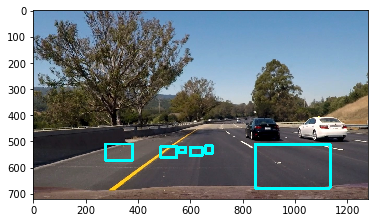

In [280]:
%matplotlib inline

image = mpimg.imread('C:\\data\\distortion\\test6.jpg')

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], (0,255,255), 10)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), 
          ((554, 543), (582, 522)), ((601, 555), (646, 522)), 
          ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

result = draw_boxes(image, bboxes)
plt.imshow(result)

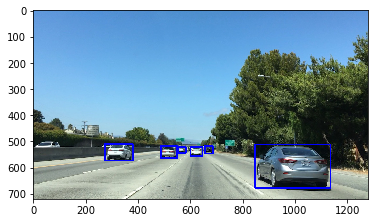

In [281]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')
#image = mpimg.imread('temp-matching-example-2.jpg')
#templist = ['cutout1.jpg', 'cutout2.jpg', 'cutout3.jpg',
#            'cutout4.jpg', 'cutout5.jpg', 'cutout6.jpg']
templist = glob.glob('C:\\data\\detection\\templates\\cutout*.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    imcopy = np.copy(img)
    bbox_list = []
    for temp in template_list:
        temp_img = mpimg.imread(temp)
        res = cv2.matchTemplate(imcopy, temp_img, cv2.TM_CCORR_NORMED)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        # Determine bounding box corners for the match
        w, h = (temp_img.shape[1], temp_img.shape[0])
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
    # Return the list of bounding boxes
    return bbox_list

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

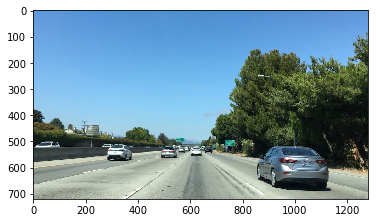

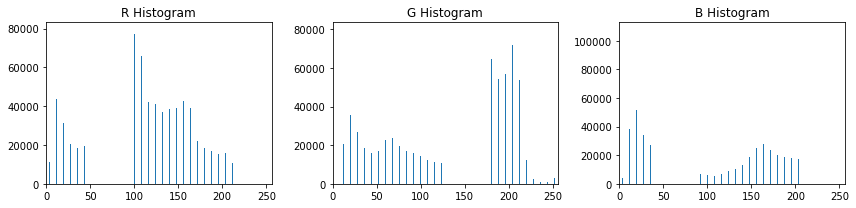

In [310]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    plt.imshow(image)
    fig = plt.figure(figsize=(12,3))
    
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    
else:
    print('Your function is returning None for at least one variable...')

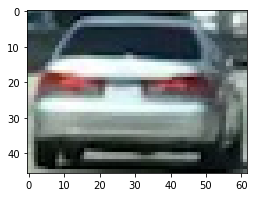

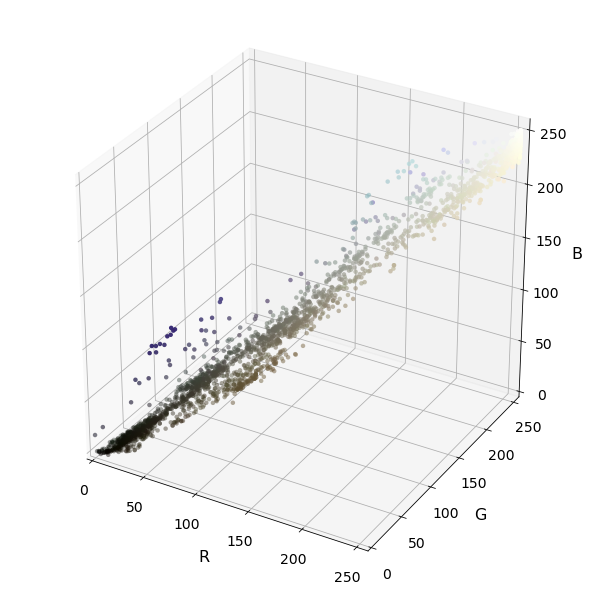

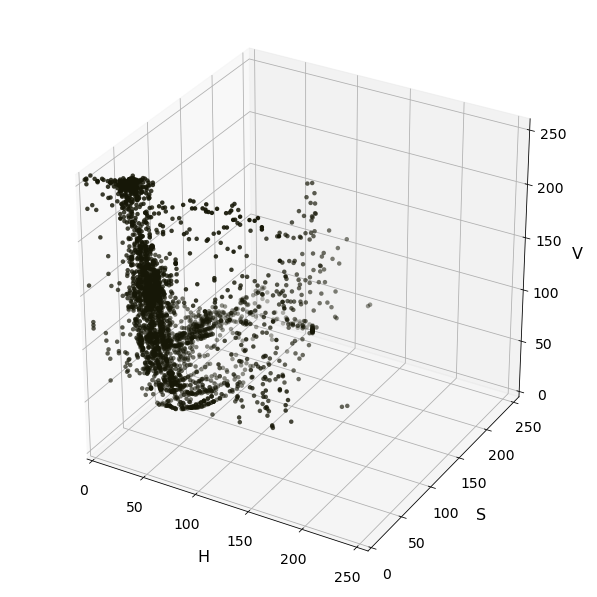

In [313]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = mpimg.imread('C:\\data\\detection\\templates\\cutout2.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 256) / 256  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
#img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

plt.figure(figsize=(12,3))
plt.imshow(img)

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

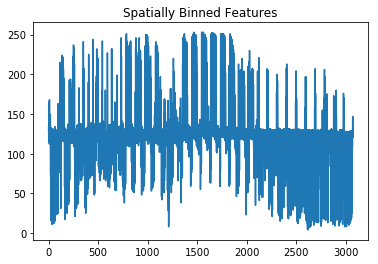

In [288]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('C:\\data\\detection\\templates\\cutout1.jpg')

# compute color histogram features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space == 'RGB':
        feature_image = np.copy(img)   
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
       
    # create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    return features
    
feature_vec = bin_spatial(image, color_space='YUV', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')



Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


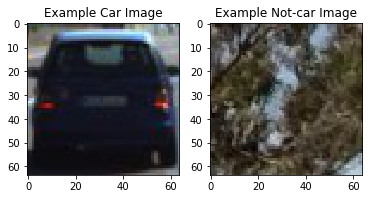

In [294]:


images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')

cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    image = mpimg.imread(car_list[0])
    data_dict["image_shape"] = image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


features length =  509436


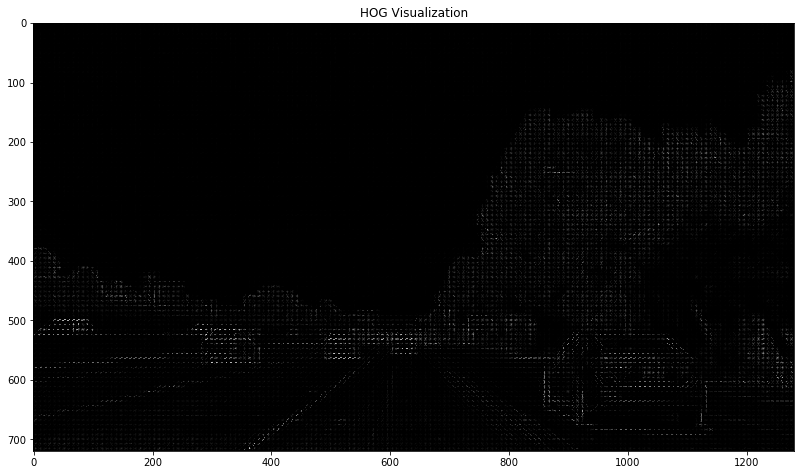

In [322]:

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


print('features length = ',len(features))
# Plot the examples
fig = plt.figure(figsize=(30,9))
#plt.subplot(121)
#plt.imshow(image, cmap='gray')
#plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

features length =  1764


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


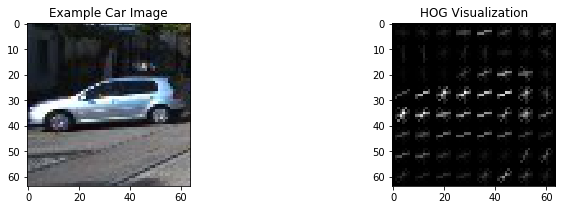

In [303]:


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features



# Read in our vehicles and non-vehicles
images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
       

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])



gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


print('features length = ',len(features))
# Plot the examples
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


In [199]:
images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))


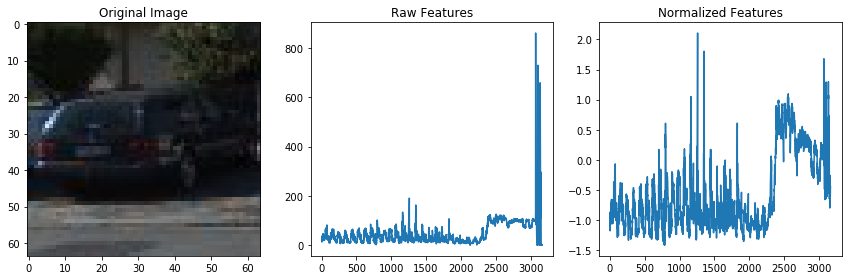

In [308]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
        # Read in each one by one
    for img in imgs:
        image = mpimg.imread(img)
    # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)  
    # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() to get color histogram features
        histogram_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, histogram_features)))
    # Return list of feature vectors
    return features

images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))


if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [182]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 64

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial, 'and', histbin, 'histogram bins')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 3264
2.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9892
My SVC predicts:      [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.001 Seconds to predict 10 labels with SVC


In [188]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 1000
cars_sample = cars[0:sample_size]
notcars_sample = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars_sample, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars_sample, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


13.61 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
0.67 Seconds to train SVC...
Test Accuracy of SVC =  0.965
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  1.]
0.001 Seconds to predict 10 labels with SVC


Total windows:  38


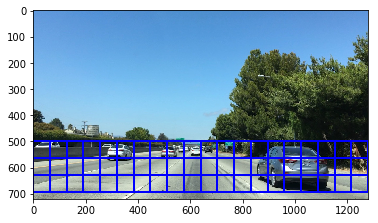

In [330]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
   # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[500, 720], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
print('Total windows: ',len(windows)                       )
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(2321, 6108)
(2321, 6108)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
0.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9892


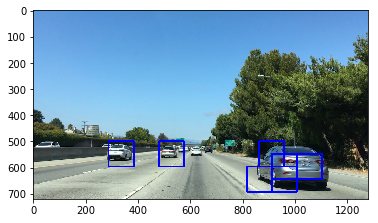

In [345]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
'''
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 100
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]
'''
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print(scaled_X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[500,700], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

output = open("svc_pickle.p", 'wb')
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, output)
output.close()

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


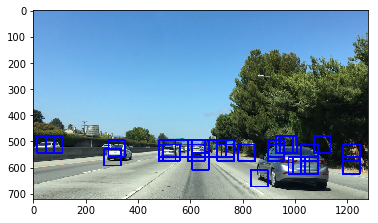

In [374]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    else:
        return img
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return draw_img

box_list = []    
ystart = 480
ystop = 700
scale = 1

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

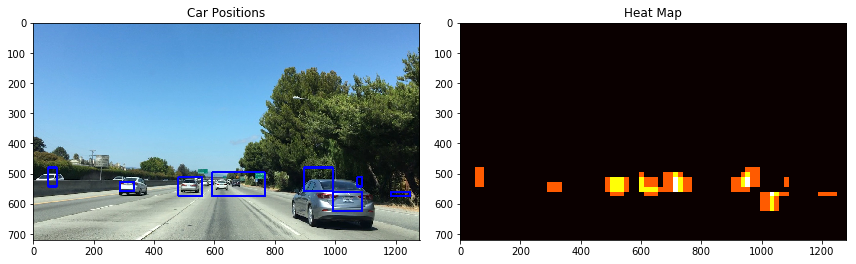

In [375]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
